## Runs DE on different clusters. Also runs DE within each cluster for each condition.
Does this over each donor and combined

In [1]:
# Input info
se_f = "/data/Mito_Trace/output/pipeline/DUPI_april08_2021/MTblacklist_mtasnucl_Bonly/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_3/concat/annotation_clones/SE.rds"
sample_names = "preB,postB"
outdir = "/data/Mito_Trace/output/pipeline/DUPI_april08_2021/MTblacklist_mtasnucl_Bonly/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_3/concat/annotation_clones/peaks_donors_DE_minPct_00"

# Parameters
assay="ATAC"
minPct = 0.00
logfcthresh = 0.25
top_de = 3
p_thresh=0.1
test.use="LR"
latent.vars = "peak_region_fragments"

# Parallel processing
cores = 4

# R utils script
utils_script <- "/data/Mito_Trace/R_scripts/seurat_utils.R"



In [2]:
source(utils_script)
outdir = outdir
dir.create(outdir, showWarnings = FALSE)

btwnConds_inClust_sepDonrs.outdir <- file.path(outdir, "btwnConds_inClust_sepDonrs")
dir.create(btwnConds_inClust_sepDonrs.outdir)

btwnConds_inClust.outdir <- file.path(outdir, "btwnConds_inClust")
dir.create(btwnConds_inClust.outdir, showWarnings = FALSE)

Attaching SeuratObject

Warning message in dir.create(btwnConds_inClust_sepDonrs.outdir):
“'/data/Mito_Trace/output/pipeline/DUPI_april08_2021/MTblacklist_mtasnucl_Bonly/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_3/concat/annotation_clones/peaks_donors_DE_minPct_00/btwnConds_inClust_sepDonrs' already exists”


In [3]:
sample_names <- unlist(strsplit(sample_names, ",")[[1]])
sample_names

[1] "preB"  "postB"

In [4]:
library(GenomicRanges)
library(Seurat)
library(Signac)
library(GenomeInfoDb)
library(EnsDb.Hsapiens.v75)
library(ggplot2)
library(patchwork)
set.seed(1234)
library(data.table)
library(magrittr)
library(cowplot)
library(metap)
library("RColorBrewer")

library(future)
plan()

plan("multiprocess", workers = cores)
#options(future.globals.maxSize = 50000 * 1024^2) # for 50 Gb RAM
options(future.globals.maxSize = 8000 * 1024^2)

Loading required package: stats4

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which.max, which.min


Loading required package: S4Vectors


Attaching package: ‘S4Vectors’


The following objects are masked from ‘package:base’:

    expand.grid, I, unname


Loading required package: IRanges

Loading required package: GenomeInfoDb

Loading required package: ensembldb

Loading required package: GenomicFeatures

Loading required package: AnnotationDbi

Lo

sequential:
- args: function (..., envir = parent.frame())
- tweaked: FALSE
- call: NULL

Warning message:
"Strategy 'multiprocess' is deprecated in future (>= 1.20.0). Instead, explicitly specify either 'multisession' or 'multicore'. In the current R session, 'multiprocess' equals 'multicore'."


In [5]:
se <- readRDS(se_f)#file.path(indir, paste0("allSamples.integrated.rds")))
DefaultAssay(se) <- assay
se

An object of class Seurat 
62328 features across 3683 samples within 2 assays 
Active assay: ATAC (42318 features, 0 variable features)
 1 other assay present: RNA
 2 dimensional reductions calculated: integrated_lsi, umap

# Stimulus specific response in each cluster 

## Each donor separately

In [6]:
se$condition.name <- as.factor(apply(se[[]][ , c("orig.ident", "seurat_clusters", "donor") ] , 1 , paste , collapse = "_" ))
se$condition.clust <- as.factor(apply(se[[]][ , c("orig.ident", "seurat_clusters") ] , 1 , paste , collapse = "_" ))

In [7]:
# get clust and donor information
source(utils_script)
clust.ids <- levels(se$seurat_clusters)
don.ids <- levels(se$donor)
#cols <- c("seurat_clusters", "donor")
curr.ids <- levels(as.factor(apply(se[[]][ , c( "seurat_clusters", "donor") ] , 1 , paste , collapse = "_" )))
# Setup Idents to include the condition, clusters and donor
Idents(se) <- as.factor(apply(se[[]][ , c("orig.ident", "seurat_clusters", "donor") ] , 1 , paste , collapse = "_" ))
se$curr.id = Idents(se)

# setup output
# all.pvals is gene-by-comparison df of the pvalue results
all.pvals <- data.frame(matrix(nrow=dim(se)[1],ncol=0),
                          row.names=row.names(se))
all.names.sig <- c()

# Loop through clusters and donors and compare between conditions
for (cl in clust.ids){
    if (cl == "None"){
        next
    }
    for (d in don.ids){
        if (d == "None"){
            print('Skipping None')
            next
        }
        c <- paste0(cl, "_", d)
        cl.names.sig = c()
        
        try({
            print("c")
            print(c)
            id1 <- paste(sample_names[[1]], c, sep="_")
            id2 <- paste(sample_names[[2]], c, sep="_")         
            curr.name <- c
            curr.name <- paste(c, sample_names[[1]], sample_names[[2]], sep='_')
            curr.clust.donor.outdir <- file.path(btwnConds_inClust_sepDonrs.outdir,
                                                 paste0("clust_", cl, "donor_", d))
            dir.create(curr.clust.donor.outdir)

            curr.sig <- find.markers.and.plot(se, id1, id2, curr.clust.donor.outdir, 
                                              curr.name=curr.name, 
                                              latent.var=latent.vars, test.use=test.use,
                                              min.pct=minPct, p.thresh=p_thresh)
            if (length(names(curr.sig)) > 0){
                print("adding sig vals to all pvals")
                names.sig <- rownames(curr.sig)
                all.names.sig <- c(all.names.sig, head(names.sig, top_de))
                all.pvals[names.sig,curr.name] <- curr.sig$p_val_adj_BH
            }else{
                print("no sig variables found")
            }
        })
    }
}

[1] "c"
[1] "0_0"


Warning message in dir.create(curr.clust.donor.outdir):
"'/data/Mito_Trace/output/pipeline/DUPI_april08_2021/MTblacklist_mtasnucl_Bonly/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_3/concat/annotation_clones/genes_donors_DE_minPct_00/btwnConds_inClust_sepDonrs/clust_0donor_0' already exists"


[1] "curr sig"
                     p_val  avg_diff pct.1 pct.2 p_val_adj p_val_adj_BH
AP001055.1    6.415656e-06 0.2539823 0.432 0.075 0.1283773  0.003805832
HAMP          1.094204e-05 0.2599499 0.432 0.060 0.2189502  0.003805832
FEM1A         1.156141e-05 0.3437022 0.757 0.254 0.2313437  0.003805832
CTTN          1.195215e-05 0.1952778 0.351 0.030 0.2391626  0.003805832
CTD-2535L24.2 1.224449e-05 0.4787773 0.865 0.478 0.2450122  0.003805832
FCAR          1.872405e-05 0.3414444 0.676 0.224 0.3746682  0.003805832
[1] "dim response"
[1] 1601    6
[1] "response plots"
                     p_val  avg_diff pct.1 pct.2 p_val_adj p_val_adj_BH
AP001055.1    6.415656e-06 0.2539823 0.432 0.075 0.1283773  0.003805832
HAMP          1.094204e-05 0.2599499 0.432 0.060 0.2189502  0.003805832
FEM1A         1.156141e-05 0.3437022 0.757 0.254 0.2313437  0.003805832
CTTN          1.195215e-05 0.1952778 0.351 0.030 0.2391626  0.003805832
CTD-2535L24.2 1.224449e-05 0.4787773 0.865 0.478 0.2450122  0.00380

'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



                     p_val  avg_diff pct.1 pct.2 p_val_adj p_val_adj_BH
AP001055.1    6.415656e-06 0.2539823 0.432 0.075 0.1283773  0.003805832
HAMP          1.094204e-05 0.2599499 0.432 0.060 0.2189502  0.003805832
FEM1A         1.156141e-05 0.3437022 0.757 0.254 0.2313437  0.003805832
CTTN          1.195215e-05 0.1952778 0.351 0.030 0.2391626  0.003805832
CTD-2535L24.2 1.224449e-05 0.4787773 0.865 0.478 0.2450122  0.003805832
FCAR          1.872405e-05 0.3414444 0.676 0.224 0.3746682  0.003805832


Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2

Saving 6.67 x 6.67 in image



[1] "adding sig vals to all pvals"
[1] "c"
[1] "0_1"


Warning message in dir.create(curr.clust.donor.outdir):
"'/data/Mito_Trace/output/pipeline/DUPI_april08_2021/MTblacklist_mtasnucl_Bonly/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_3/concat/annotation_clones/genes_donors_DE_minPct_00/btwnConds_inClust_sepDonrs/clust_0donor_1' already exists"


[1] "curr sig"
                p_val   avg_diff pct.1 pct.2   p_val_adj p_val_adj_BH
SLC39A11 4.516161e-07 -0.3389244 0.215 0.537 0.009036839 0.0004854873
GPC3     4.575121e-06 -0.2100053 0.054 0.325 0.091548164 0.0024591274
PACS1    7.028103e-06  0.3679386 0.882 0.738 0.140632342 0.0025184036
CPNE8    1.173995e-05 -0.2430896 0.054 0.300 0.234916318 0.0031551105
DKK2     2.221015e-05  0.3758745 0.925 0.775 0.444425045 0.0047005692
KANSL1L  2.697263e-05 -0.1492037 0.022 0.225 0.539722281 0.0047005692
[1] "dim response"
[1] 1075    6
[1] "response plots"
                p_val   avg_diff pct.1 pct.2   p_val_adj p_val_adj_BH
SLC39A11 4.516161e-07 -0.3389244 0.215 0.537 0.009036839 0.0004854873
GPC3     4.575121e-06 -0.2100053 0.054 0.325 0.091548164 0.0024591274
PACS1    7.028103e-06  0.3679386 0.882 0.738 0.140632342 0.0025184036
CPNE8    1.173995e-05 -0.2430896 0.054 0.300 0.234916318 0.0031551105
DKK2     2.221015e-05  0.3758745 0.925 0.775 0.444425045 0.0047005692
KANSL1L  2.697263e-05

'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



                p_val   avg_diff pct.1 pct.2   p_val_adj p_val_adj_BH
SLC39A11 4.516161e-07 -0.3389244 0.215 0.537 0.009036839 0.0004854873
GPC3     4.575121e-06 -0.2100053 0.054 0.325 0.091548164 0.0024591274
PACS1    7.028103e-06  0.3679386 0.882 0.738 0.140632342 0.0025184036
CPNE8    1.173995e-05 -0.2430896 0.054 0.300 0.234916318 0.0031551105
DKK2     2.221015e-05  0.3758745 0.925 0.775 0.444425045 0.0047005692
KANSL1L  2.697263e-05 -0.1492037 0.022 0.225 0.539722281 0.0047005692


Saving 6.67 x 6.67 in image



[1] "adding sig vals to all pvals"
[1] "c"
[1] "0_2"


Warning message in dir.create(curr.clust.donor.outdir):
"'/data/Mito_Trace/output/pipeline/DUPI_april08_2021/MTblacklist_mtasnucl_Bonly/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_3/concat/annotation_clones/genes_donors_DE_minPct_00/btwnConds_inClust_sepDonrs/clust_0donor_2' already exists"


[1] "curr sig"
[1] p_val        avg_diff     pct.1        pct.2        p_val_adj   
[6] p_val_adj_BH
<0 rows> (or 0-length row.names)
[1] "dim response"
[1] 3147    6
[1] "response plots"
              p_val   avg_diff pct.1 pct.2 p_val_adj p_val_adj_BH
TAF8   0.0001761481  0.5513952 0.733 0.125         1    0.2020969
STAP2  0.0002076070  0.5608528 0.700 0.062         1    0.2020969
SRL    0.0003068436  0.4984761 0.567 0.000         1    0.2020969
HMGCS1 0.0004462329  0.4684470 0.667 0.062         1    0.2020969
SCLT1  0.0004806983 -0.4936243 0.033 0.438         1    0.2020969
GRM3   0.0005835192 -0.3959107 0.033 0.438         1    0.2020969
character(0)
Error in FetchData(object = object, vars = features, cells = cells) : 
  None of the requested variables were found: 
[1] "c"
[1] "0_3"


Warning message in dir.create(curr.clust.donor.outdir):
"'/data/Mito_Trace/output/pipeline/DUPI_april08_2021/MTblacklist_mtasnucl_Bonly/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_3/concat/annotation_clones/genes_donors_DE_minPct_00/btwnConds_inClust_sepDonrs/clust_0donor_3' already exists"


[1] "curr sig"
               p_val  avg_diff pct.1 pct.2    p_val_adj p_val_adj_BH
FAM72B  2.732300e-25 0.2311132 0.261 0.000 5.467331e-21 2.502786e-22
HSFY2   3.023627e-19 0.1349158 0.196 0.000 6.050277e-15 1.384821e-16
SGK223  1.389169e-13 0.1987694 0.217 0.012 2.779728e-09 4.241597e-11
SCAMP3  3.019760e-06 0.2026837 0.326 0.094 6.042541e-02 6.915251e-04
CXorf58 1.027075e-05 0.1334115 0.196 0.040 2.055177e-01 1.881602e-03
ISM1    2.092901e-05 0.2986482 0.543 0.270 4.187895e-01 3.195162e-03
[1] "dim response"
[1] 916   6
[1] "response plots"
               p_val  avg_diff pct.1 pct.2    p_val_adj p_val_adj_BH
FAM72B  2.732300e-25 0.2311132 0.261 0.000 5.467331e-21 2.502786e-22
HSFY2   3.023627e-19 0.1349158 0.196 0.000 6.050277e-15 1.384821e-16
SGK223  1.389169e-13 0.1987694 0.217 0.012 2.779728e-09 4.241597e-11
SCAMP3  3.019760e-06 0.2026837 0.326 0.094 6.042541e-02 6.915251e-04
CXorf58 1.027075e-05 0.1334115 0.196 0.040 2.055177e-01 1.881602e-03
ISM1    2.092901e-05 0.2986482 0.543

'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



               p_val  avg_diff pct.1 pct.2    p_val_adj p_val_adj_BH
FAM72B  2.732300e-25 0.2311132 0.261 0.000 5.467331e-21 2.502786e-22
HSFY2   3.023627e-19 0.1349158 0.196 0.000 6.050277e-15 1.384821e-16
SGK223  1.389169e-13 0.1987694 0.217 0.012 2.779728e-09 4.241597e-11
SCAMP3  3.019760e-06 0.2026837 0.326 0.094 6.042541e-02 6.915251e-04
CXorf58 1.027075e-05 0.1334115 0.196 0.040 2.055177e-01 1.881602e-03
ISM1    2.092901e-05 0.2986482 0.543 0.270 4.187895e-01 3.195162e-03


Saving 6.67 x 6.67 in image



[1] "adding sig vals to all pvals"
[1] "Skipping None"
[1] "c"
[1] "1_0"


Warning message in dir.create(curr.clust.donor.outdir):
"'/data/Mito_Trace/output/pipeline/DUPI_april08_2021/MTblacklist_mtasnucl_Bonly/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_3/concat/annotation_clones/genes_donors_DE_minPct_00/btwnConds_inClust_sepDonrs/clust_1donor_0' already exists"


[1] "curr sig"
              p_val  avg_diff pct.1 pct.2   p_val_adj p_val_adj_BH
GINS1  4.279834e-07 0.2732803 0.575 0.077 0.008563947 0.0004745954
FANCA  5.902928e-07 0.4119292 0.750 0.231 0.011811760 0.0004745954
ZNF490 2.141461e-06 0.3102485 0.700 0.192 0.042850643 0.0010082500
ZNF791 2.508085e-06 0.2868969 0.675 0.173 0.050186773 0.0010082500
TMBIM6 7.181508e-06 0.3173851 0.700 0.212 0.143701978 0.0023095730
COTL1  9.953712e-06 0.3007801 0.650 0.250 0.199173777 0.0026188319
[1] "dim response"
[1] 1608    6
[1] "response plots"
              p_val  avg_diff pct.1 pct.2   p_val_adj p_val_adj_BH
GINS1  4.279834e-07 0.2732803 0.575 0.077 0.008563947 0.0004745954
FANCA  5.902928e-07 0.4119292 0.750 0.231 0.011811760 0.0004745954
ZNF490 2.141461e-06 0.3102485 0.700 0.192 0.042850643 0.0010082500
ZNF791 2.508085e-06 0.2868969 0.675 0.173 0.050186773 0.0010082500
TMBIM6 7.181508e-06 0.3173851 0.700 0.212 0.143701978 0.0023095730
COTL1  9.953712e-06 0.3007801 0.650 0.250 0.199173777 0.0026

'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



              p_val  avg_diff pct.1 pct.2   p_val_adj p_val_adj_BH
GINS1  4.279834e-07 0.2732803 0.575 0.077 0.008563947 0.0004745954
FANCA  5.902928e-07 0.4119292 0.750 0.231 0.011811760 0.0004745954
ZNF490 2.141461e-06 0.3102485 0.700 0.192 0.042850643 0.0010082500
ZNF791 2.508085e-06 0.2868969 0.675 0.173 0.050186773 0.0010082500
TMBIM6 7.181508e-06 0.3173851 0.700 0.212 0.143701978 0.0023095730
COTL1  9.953712e-06 0.3007801 0.650 0.250 0.199173777 0.0026188319


Saving 6.67 x 6.67 in image



[1] "adding sig vals to all pvals"
[1] "c"
[1] "1_1"


Warning message in dir.create(curr.clust.donor.outdir):
"'/data/Mito_Trace/output/pipeline/DUPI_april08_2021/MTblacklist_mtasnucl_Bonly/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_3/concat/annotation_clones/genes_donors_DE_minPct_00/btwnConds_inClust_sepDonrs/clust_1donor_1' already exists"


[1] "curr sig"
[1] p_val        avg_diff     pct.1        pct.2        p_val_adj   
[6] p_val_adj_BH
<0 rows> (or 0-length row.names)
[1] "dim response"
[1] 1732    6
[1] "response plots"
                   p_val   avg_diff pct.1 pct.2 p_val_adj p_val_adj_BH
C1orf112    0.0002637058  0.4314940 0.725  0.20         1    0.1840759
PPP2R2C     0.0007952695 -0.2631206 0.050  0.36         1    0.1840759
STAG2       0.0008567030 -0.2720946 0.050  0.36         1    0.1840759
RAB8B       0.0009096041  0.3662507 0.750  0.48         1    0.1840759
TMX2-CTNND1 0.0009635353  0.3513651 0.575  0.16         1    0.1840759
SLIT2       0.0009652636 -0.2833510 0.075  0.40         1    0.1840759
character(0)
Error in FetchData(object = object, vars = features, cells = cells) : 
  None of the requested variables were found: 
[1] "c"
[1] "1_2"


Warning message in dir.create(curr.clust.donor.outdir):
"'/data/Mito_Trace/output/pipeline/DUPI_april08_2021/MTblacklist_mtasnucl_Bonly/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_3/concat/annotation_clones/genes_donors_DE_minPct_00/btwnConds_inClust_sepDonrs/clust_1donor_2' already exists"


[1] "curr sig"
                p_val  avg_diff pct.1 pct.2 p_val_adj p_val_adj_BH
DKKL1    1.841734e-05 0.4628457 0.785 0.217 0.3685310    0.0337306
NPC1L1   3.352692e-05 0.3417917 0.608 0.087 0.6708736    0.0337306
TOPORS   5.510168e-05 0.3094698 0.544 0.043 1.0000000    0.0337306
PPP3R1   1.271089e-04 0.4245071 0.759 0.217 1.0000000    0.0337306
EBNA1BP2 1.350310e-04 0.3507300 0.595 0.130 1.0000000    0.0337306
WDR65    1.350310e-04 0.3507300 0.595 0.130 1.0000000    0.0337306
[1] "dim response"
[1] 2099    6
[1] "response plots"
                p_val  avg_diff pct.1 pct.2 p_val_adj p_val_adj_BH
DKKL1    1.841734e-05 0.4628457 0.785 0.217 0.3685310    0.0337306
NPC1L1   3.352692e-05 0.3417917 0.608 0.087 0.6708736    0.0337306
TOPORS   5.510168e-05 0.3094698 0.544 0.043 1.0000000    0.0337306
PPP3R1   1.271089e-04 0.4245071 0.759 0.217 1.0000000    0.0337306
EBNA1BP2 1.350310e-04 0.3507300 0.595 0.130 1.0000000    0.0337306
WDR65    1.350310e-04 0.3507300 0.595 0.130 1.0000000    0.0

'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



                p_val  avg_diff pct.1 pct.2 p_val_adj p_val_adj_BH
DKKL1    1.841734e-05 0.4628457 0.785 0.217 0.3685310    0.0337306
NPC1L1   3.352692e-05 0.3417917 0.608 0.087 0.6708736    0.0337306
TOPORS   5.510168e-05 0.3094698 0.544 0.043 1.0000000    0.0337306
PPP3R1   1.271089e-04 0.4245071 0.759 0.217 1.0000000    0.0337306
EBNA1BP2 1.350310e-04 0.3507300 0.595 0.130 1.0000000    0.0337306
WDR65    1.350310e-04 0.3507300 0.595 0.130 1.0000000    0.0337306


Saving 6.67 x 6.67 in image



[1] "adding sig vals to all pvals"
[1] "c"
[1] "1_3"


Warning message in dir.create(curr.clust.donor.outdir):
"'/data/Mito_Trace/output/pipeline/DUPI_april08_2021/MTblacklist_mtasnucl_Bonly/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_3/concat/annotation_clones/genes_donors_DE_minPct_00/btwnConds_inClust_sepDonrs/clust_1donor_3' already exists"


[1] "curr sig"
                 p_val  avg_diff pct.1 pct.2    p_val_adj p_val_adj_BH
FAM72B    3.909316e-41 0.4910110 0.645 0.000 7.822541e-37 4.331522e-38
SGK223    1.922655e-23 0.3355308 0.516 0.023 3.847233e-19 1.065151e-20
ASPSCR1   8.169732e-06 0.1195445 0.226 0.034 1.634763e-01 2.761059e-03
HIST1H2BC 1.134520e-05 0.2646656 0.516 0.198 2.270174e-01 2.761059e-03
AKT2      1.245965e-05 0.4198027 0.839 0.538 2.493176e-01 2.761059e-03
SLC30A3   1.556009e-05 0.2854540 0.581 0.248 3.113573e-01 2.873429e-03
[1] "dim response"
[1] 1108    6
[1] "response plots"
                 p_val  avg_diff pct.1 pct.2    p_val_adj p_val_adj_BH
FAM72B    3.909316e-41 0.4910110 0.645 0.000 7.822541e-37 4.331522e-38
SGK223    1.922655e-23 0.3355308 0.516 0.023 3.847233e-19 1.065151e-20
ASPSCR1   8.169732e-06 0.1195445 0.226 0.034 1.634763e-01 2.761059e-03
HIST1H2BC 1.134520e-05 0.2646656 0.516 0.198 2.270174e-01 2.761059e-03
AKT2      1.245965e-05 0.4198027 0.839 0.538 2.493176e-01 2.761059e-03
SLC30A3 

'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



                 p_val  avg_diff pct.1 pct.2    p_val_adj p_val_adj_BH
FAM72B    3.909316e-41 0.4910110 0.645 0.000 7.822541e-37 4.331522e-38
SGK223    1.922655e-23 0.3355308 0.516 0.023 3.847233e-19 1.065151e-20
ASPSCR1   8.169732e-06 0.1195445 0.226 0.034 1.634763e-01 2.761059e-03
HIST1H2BC 1.134520e-05 0.2646656 0.516 0.198 2.270174e-01 2.761059e-03
AKT2      1.245965e-05 0.4198027 0.839 0.538 2.493176e-01 2.761059e-03
SLC30A3   1.556009e-05 0.2854540 0.581 0.248 3.113573e-01 2.873429e-03


Saving 6.67 x 6.67 in image



[1] "adding sig vals to all pvals"
[1] "Skipping None"
[1] "c"
[1] "2_0"


Warning message in dir.create(curr.clust.donor.outdir):
"'/data/Mito_Trace/output/pipeline/DUPI_april08_2021/MTblacklist_mtasnucl_Bonly/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_3/concat/annotation_clones/genes_donors_DE_minPct_00/btwnConds_inClust_sepDonrs/clust_2donor_0' already exists"


[1] "curr sig"
[1] p_val        avg_diff     pct.1        pct.2        p_val_adj   
[6] p_val_adj_BH
<0 rows> (or 0-length row.names)
[1] "dim response"
[1] 2169    6
[1] "response plots"
               p_val  avg_diff pct.1 pct.2 p_val_adj p_val_adj_BH
TAF8    0.0003492747 0.3970103 0.464 0.062         1    0.2003956
RYBP    0.0004660734 0.3525117 0.393 0.031         1    0.2003956
SLC11A1 0.0005459924 0.3270467 0.393 0.031         1    0.2003956
FAM167A 0.0005459924 0.3228553 0.393 0.031         1    0.2003956
SLC35B3 0.0007454929 0.3278861 0.393 0.031         1    0.2003956
C8orf12 0.0008050046 0.2870214 0.393 0.031         1    0.2003956
character(0)
Error in FetchData(object = object, vars = features, cells = cells) : 
  None of the requested variables were found: 
[1] "c"
[1] "2_1"


Warning message in dir.create(curr.clust.donor.outdir):
"'/data/Mito_Trace/output/pipeline/DUPI_april08_2021/MTblacklist_mtasnucl_Bonly/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_3/concat/annotation_clones/genes_donors_DE_minPct_00/btwnConds_inClust_sepDonrs/clust_2donor_1' already exists"


[1] "curr sig"
               p_val   avg_diff pct.1 pct.2 p_val_adj p_val_adj_BH
GAREM   1.546175e-05 -0.3432863 0.056 0.371 0.3093896   0.01804373
PLXDC2  2.238676e-05 -0.3412981 0.070 0.400 0.4479591   0.01804373
USP34   3.959090e-05  0.5970464 0.704 0.343 0.7922139   0.02127351
XIRP2   2.095776e-04 -0.2802344 0.085 0.371 1.0000000   0.08445976
SIPA1L1 3.088319e-04 -0.2457492 0.042 0.286 1.0000000   0.09278548
WASL    3.644675e-04 -0.1697413 0.000 0.171 1.0000000   0.09278548
[1] "dim response"
[1] 1612    6
[1] "response plots"
               p_val   avg_diff pct.1 pct.2 p_val_adj p_val_adj_BH
GAREM   1.546175e-05 -0.3432863 0.056 0.371 0.3093896   0.01804373
PLXDC2  2.238676e-05 -0.3412981 0.070 0.400 0.4479591   0.01804373
USP34   3.959090e-05  0.5970464 0.704 0.343 0.7922139   0.02127351
XIRP2   2.095776e-04 -0.2802344 0.085 0.371 1.0000000   0.08445976
SIPA1L1 3.088319e-04 -0.2457492 0.042 0.286 1.0000000   0.09278548
WASL    3.644675e-04 -0.1697413 0.000 0.171 1.0000000   0.09

'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



               p_val   avg_diff pct.1 pct.2 p_val_adj p_val_adj_BH
GAREM   1.546175e-05 -0.3432863 0.056 0.371 0.3093896   0.01804373
PLXDC2  2.238676e-05 -0.3412981 0.070 0.400 0.4479591   0.01804373
USP34   3.959090e-05  0.5970464 0.704 0.343 0.7922139   0.02127351
XIRP2   2.095776e-04 -0.2802344 0.085 0.371 1.0000000   0.08445976
SIPA1L1 3.088319e-04 -0.2457492 0.042 0.286 1.0000000   0.09278548
WASL    3.644675e-04 -0.1697413 0.000 0.171 1.0000000   0.09278548


Saving 6.67 x 6.67 in image



[1] "adding sig vals to all pvals"
[1] "c"
[1] "2_2"


Warning message in dir.create(curr.clust.donor.outdir):
"'/data/Mito_Trace/output/pipeline/DUPI_april08_2021/MTblacklist_mtasnucl_Bonly/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_3/concat/annotation_clones/genes_donors_DE_minPct_00/btwnConds_inClust_sepDonrs/clust_2donor_2' already exists"


[1] "curr sig"
                p_val   avg_diff pct.1 pct.2    p_val_adj p_val_adj_BH
ITPA     1.539515e-10 -0.3814137     0   0.5 3.080569e-06 6.013904e-08
FASLG    1.539515e-10 -0.5602150     0   0.5 3.080569e-06 6.013904e-08
DSP      1.539515e-10 -0.3508307     0   0.5 3.080569e-06 6.013904e-08
KLHL31   1.539515e-10 -0.3508307     0   0.5 3.080569e-06 6.013904e-08
PPP1R14C 1.539515e-10 -0.3508307     0   0.5 3.080569e-06 6.013904e-08
ATP13A4  1.539515e-10 -0.3508307     0   0.5 3.080569e-06 6.013904e-08
[1] "dim response"
[1] 4297    6
[1] "response plots"
                p_val   avg_diff pct.1 pct.2    p_val_adj p_val_adj_BH
ITPA     1.539515e-10 -0.3814137     0   0.5 3.080569e-06 6.013904e-08
FASLG    1.539515e-10 -0.5602150     0   0.5 3.080569e-06 6.013904e-08
DSP      1.539515e-10 -0.3508307     0   0.5 3.080569e-06 6.013904e-08
KLHL31   1.539515e-10 -0.3508307     0   0.5 3.080569e-06 6.013904e-08
PPP1R14C 1.539515e-10 -0.3508307     0   0.5 3.080569e-06 6.013904e-08
ATP13A4 

'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



                p_val   avg_diff pct.1 pct.2    p_val_adj p_val_adj_BH
ITPA     1.539515e-10 -0.3814137     0   0.5 3.080569e-06 6.013904e-08
FASLG    1.539515e-10 -0.5602150     0   0.5 3.080569e-06 6.013904e-08
DSP      1.539515e-10 -0.3508307     0   0.5 3.080569e-06 6.013904e-08
KLHL31   1.539515e-10 -0.3508307     0   0.5 3.080569e-06 6.013904e-08
PPP1R14C 1.539515e-10 -0.3508307     0   0.5 3.080569e-06 6.013904e-08
ATP13A4  1.539515e-10 -0.3508307     0   0.5 3.080569e-06 6.013904e-08


Saving 6.67 x 6.67 in image



[1] "adding sig vals to all pvals"
[1] "c"
[1] "2_3"


Warning message in dir.create(curr.clust.donor.outdir):
"'/data/Mito_Trace/output/pipeline/DUPI_april08_2021/MTblacklist_mtasnucl_Bonly/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_3/concat/annotation_clones/genes_donors_DE_minPct_00/btwnConds_inClust_sepDonrs/clust_2donor_3' already exists"


[1] "curr sig"
              p_val  avg_diff pct.1 pct.2    p_val_adj p_val_adj_BH
SGK223 3.269000e-18 0.5769848 0.548 0.040 6.541268e-14 4.501412e-15
FAM72B 8.091465e-12 0.2241776 0.226 0.000 1.619102e-07 5.570974e-09
HSFY2  9.288795e-06 0.1004274 0.097 0.000 1.858688e-01 4.263557e-03
GPR114 3.508621e-05 0.2754227 0.290 0.064 7.020751e-01 1.207843e-02
KCNH2  6.808465e-05 0.2653684 0.355 0.099 1.000000e+00 1.447284e-02
BCL2L1 7.530568e-05 0.2295374 0.226 0.040 1.000000e+00 1.447284e-02
[1] "dim response"
[1] 1377    6
[1] "response plots"
              p_val  avg_diff pct.1 pct.2    p_val_adj p_val_adj_BH
SGK223 3.269000e-18 0.5769848 0.548 0.040 6.541268e-14 4.501412e-15
FAM72B 8.091465e-12 0.2241776 0.226 0.000 1.619102e-07 5.570974e-09
HSFY2  9.288795e-06 0.1004274 0.097 0.000 1.858688e-01 4.263557e-03
GPR114 3.508621e-05 0.2754227 0.290 0.064 7.020751e-01 1.207843e-02
KCNH2  6.808465e-05 0.2653684 0.355 0.099 1.000000e+00 1.447284e-02
BCL2L1 7.530568e-05 0.2295374 0.226 0.040 1.000

'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



              p_val  avg_diff pct.1 pct.2    p_val_adj p_val_adj_BH
SGK223 3.269000e-18 0.5769848 0.548 0.040 6.541268e-14 4.501412e-15
FAM72B 8.091465e-12 0.2241776 0.226 0.000 1.619102e-07 5.570974e-09
HSFY2  9.288795e-06 0.1004274 0.097 0.000 1.858688e-01 4.263557e-03
GPR114 3.508621e-05 0.2754227 0.290 0.064 7.020751e-01 1.207843e-02
KCNH2  6.808465e-05 0.2653684 0.355 0.099 1.000000e+00 1.447284e-02
BCL2L1 7.530568e-05 0.2295374 0.226 0.040 1.000000e+00 1.447284e-02


Saving 6.67 x 6.67 in image



[1] "adding sig vals to all pvals"
[1] "Skipping None"
[1] "c"
[1] "3_0"


Warning message in dir.create(curr.clust.donor.outdir):
"'/data/Mito_Trace/output/pipeline/DUPI_april08_2021/MTblacklist_mtasnucl_Bonly/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_3/concat/annotation_clones/genes_donors_DE_minPct_00/btwnConds_inClust_sepDonrs/clust_3donor_0' already exists"


[1] "curr sig"
                      p_val  avg_diff pct.1 pct.2 p_val_adj p_val_adj_BH
ZNF689         6.496887e-06 0.2911518 0.538 0.028 0.1300027   0.01229211
POLR1E         1.948503e-05 0.3258630 0.577 0.083 0.3898955   0.01843284
HMHA1          3.653686e-05 0.3479404 0.577 0.083 0.7311026   0.02304258
CHMP4B         6.371716e-05 0.1943032 0.385 0.000 1.0000000   0.02670520
SSBP3          7.745845e-05 0.4027465 0.846 0.306 1.0000000   0.02670520
RP11-1035H13.3 1.115625e-04 0.2448940 0.500 0.056 1.0000000   0.02670520
[1] "dim response"
[1] 1892    6
[1] "response plots"
                      p_val  avg_diff pct.1 pct.2 p_val_adj p_val_adj_BH
ZNF689         6.496887e-06 0.2911518 0.538 0.028 0.1300027   0.01229211
POLR1E         1.948503e-05 0.3258630 0.577 0.083 0.3898955   0.01843284
HMHA1          3.653686e-05 0.3479404 0.577 0.083 0.7311026   0.02304258
CHMP4B         6.371716e-05 0.1943032 0.385 0.000 1.0000000   0.02670520
SSBP3          7.745845e-05 0.4027465 0.846 0.306 1.000

'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



                      p_val  avg_diff pct.1 pct.2 p_val_adj p_val_adj_BH
ZNF689         6.496887e-06 0.2911518 0.538 0.028 0.1300027   0.01229211
POLR1E         1.948503e-05 0.3258630 0.577 0.083 0.3898955   0.01843284
HMHA1          3.653686e-05 0.3479404 0.577 0.083 0.7311026   0.02304258
CHMP4B         6.371716e-05 0.1943032 0.385 0.000 1.0000000   0.02670520
SSBP3          7.745845e-05 0.4027465 0.846 0.306 1.0000000   0.02670520
RP11-1035H13.3 1.115625e-04 0.2448940 0.500 0.056 1.0000000   0.02670520


Saving 6.67 x 6.67 in image



[1] "adding sig vals to all pvals"
[1] "c"
[1] "3_1"


Warning message in dir.create(curr.clust.donor.outdir):
"'/data/Mito_Trace/output/pipeline/DUPI_april08_2021/MTblacklist_mtasnucl_Bonly/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_3/concat/annotation_clones/genes_donors_DE_minPct_00/btwnConds_inClust_sepDonrs/clust_3donor_1' already exists"


[1] "curr sig"
              p_val  avg_diff pct.1 pct.2  p_val_adj p_val_adj_BH
AGFG2  6.691023e-07 0.3621864 0.642 0.145 0.01338874 0.0009802348
DNAJA3 2.639274e-06 0.3065662 0.528 0.109 0.05281188 0.0014483721
DDX39A 3.141525e-06 0.3300589 0.660 0.200 0.06286192 0.0014483721
ZNF233 3.954600e-06 0.2782176 0.509 0.091 0.07913154 0.0014483721
CLK2   1.042160e-05 0.1706430 0.358 0.018 0.20853624 0.0030535291
SCNN1A 2.120074e-05 0.3031620 0.660 0.200 0.42422687 0.0051765148
[1] "dim response"
[1] 1465    6
[1] "response plots"
              p_val  avg_diff pct.1 pct.2  p_val_adj p_val_adj_BH
AGFG2  6.691023e-07 0.3621864 0.642 0.145 0.01338874 0.0009802348
DNAJA3 2.639274e-06 0.3065662 0.528 0.109 0.05281188 0.0014483721
DDX39A 3.141525e-06 0.3300589 0.660 0.200 0.06286192 0.0014483721
ZNF233 3.954600e-06 0.2782176 0.509 0.091 0.07913154 0.0014483721
CLK2   1.042160e-05 0.1706430 0.358 0.018 0.20853624 0.0030535291
SCNN1A 2.120074e-05 0.3031620 0.660 0.200 0.42422687 0.0051765148
[1] "AG

'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



              p_val  avg_diff pct.1 pct.2  p_val_adj p_val_adj_BH
AGFG2  6.691023e-07 0.3621864 0.642 0.145 0.01338874 0.0009802348
DNAJA3 2.639274e-06 0.3065662 0.528 0.109 0.05281188 0.0014483721
DDX39A 3.141525e-06 0.3300589 0.660 0.200 0.06286192 0.0014483721
ZNF233 3.954600e-06 0.2782176 0.509 0.091 0.07913154 0.0014483721
CLK2   1.042160e-05 0.1706430 0.358 0.018 0.20853624 0.0030535291
SCNN1A 2.120074e-05 0.3031620 0.660 0.200 0.42422687 0.0051765148


Saving 6.67 x 6.67 in image



[1] "adding sig vals to all pvals"
[1] "c"
[1] "3_2"


Warning message in dir.create(curr.clust.donor.outdir):
"'/data/Mito_Trace/output/pipeline/DUPI_april08_2021/MTblacklist_mtasnucl_Bonly/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_3/concat/annotation_clones/genes_donors_DE_minPct_00/btwnConds_inClust_sepDonrs/clust_3donor_2' already exists"


[1] "curr sig"
[1] p_val        avg_diff     pct.1        pct.2        p_val_adj   
[6] p_val_adj_BH
<0 rows> (or 0-length row.names)
[1] "dim response"
[1] 3884    6
[1] "response plots"
                p_val  avg_diff pct.1 pct.2 p_val_adj p_val_adj_BH
CR1      0.0007145978 0.4739419 0.667 0.000         1    0.4248624
LRRC63   0.0007145978 0.4992200 0.667 0.000         1    0.4248624
GLTSCR1L 0.0008780167 0.5601026 0.778 0.143         1    0.4248624
PI4K2B   0.0023598021 0.5349474 0.778 0.143         1    0.4248624
MMP24    0.0026106083 0.3217424 0.556 0.000         1    0.4248624
ESYT3    0.0026106083 0.4313158 0.556 0.000         1    0.4248624
character(0)
Error in FetchData(object = object, vars = features, cells = cells) : 
  None of the requested variables were found: 
[1] "c"
[1] "3_3"


Warning message in dir.create(curr.clust.donor.outdir):
"'/data/Mito_Trace/output/pipeline/DUPI_april08_2021/MTblacklist_mtasnucl_Bonly/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_3/concat/annotation_clones/genes_donors_DE_minPct_00/btwnConds_inClust_sepDonrs/clust_3donor_3' already exists"


[1] "curr sig"
              p_val  avg_diff pct.1 pct.2    p_val_adj p_val_adj_BH
FAM72B 1.164183e-45 0.4593834 0.692 0.000 2.329531e-41 2.170038e-42
SGK223 3.065940e-21 0.3650954 0.615 0.025 6.134946e-17 2.857456e-18
UTY    7.201327e-21 0.1607916 0.308 0.000 1.440986e-16 4.474424e-18
UTS2   1.345136e-16 0.1324920 0.308 0.004 2.691617e-12 6.268334e-14
UBA3   3.162355e-08 0.2093985 0.462 0.053 6.327873e-04 1.103071e-05
TIGD1  3.550656e-08 0.1398422 0.231 0.011 7.104864e-04 1.103071e-05
[1] "dim response"
[1] 1864    6
[1] "response plots"
              p_val  avg_diff pct.1 pct.2    p_val_adj p_val_adj_BH
FAM72B 1.164183e-45 0.4593834 0.692 0.000 2.329531e-41 2.170038e-42
SGK223 3.065940e-21 0.3650954 0.615 0.025 6.134946e-17 2.857456e-18
UTY    7.201327e-21 0.1607916 0.308 0.000 1.440986e-16 4.474424e-18
UTS2   1.345136e-16 0.1324920 0.308 0.004 2.691617e-12 6.268334e-14
UBA3   3.162355e-08 0.2093985 0.462 0.053 6.327873e-04 1.103071e-05
TIGD1  3.550656e-08 0.1398422 0.231 0.011 7.104

'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



              p_val  avg_diff pct.1 pct.2    p_val_adj p_val_adj_BH
FAM72B 1.164183e-45 0.4593834 0.692 0.000 2.329531e-41 2.170038e-42
SGK223 3.065940e-21 0.3650954 0.615 0.025 6.134946e-17 2.857456e-18
UTY    7.201327e-21 0.1607916 0.308 0.000 1.440986e-16 4.474424e-18
UTS2   1.345136e-16 0.1324920 0.308 0.004 2.691617e-12 6.268334e-14
UBA3   3.162355e-08 0.2093985 0.462 0.053 6.327873e-04 1.103071e-05
TIGD1  3.550656e-08 0.1398422 0.231 0.011 7.104864e-04 1.103071e-05


Saving 6.67 x 6.67 in image



[1] "adding sig vals to all pvals"
[1] "Skipping None"
[1] "c"
[1] "4_0"


Warning message in dir.create(curr.clust.donor.outdir):
"'/data/Mito_Trace/output/pipeline/DUPI_april08_2021/MTblacklist_mtasnucl_Bonly/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_3/concat/annotation_clones/genes_donors_DE_minPct_00/btwnConds_inClust_sepDonrs/clust_4donor_0' already exists"


[1] "curr sig"
                p_val  avg_diff pct.1 pct.2 p_val_adj p_val_adj_BH
WDR74    1.035017e-05 0.3453451 0.739 0.118 0.2071069   0.01249972
ALDH3A1  1.226063e-05 0.3070479 0.652 0.059 0.2453353   0.01249972
TRAF3IP1 2.868117e-05 0.4697459 0.913 0.235 0.5739103   0.01680045
NTN1     3.316190e-05 0.4465001 0.739 0.176 0.6635697   0.01680045
RARG     4.119776e-05 0.2728265 0.652 0.118 0.8243671   0.01680045
NOTCH4   5.426826e-05 0.4720676 0.870 0.265 1.0000000   0.01701595
[1] "dim response"
[1] 2039    6
[1] "response plots"
                p_val  avg_diff pct.1 pct.2 p_val_adj p_val_adj_BH
WDR74    1.035017e-05 0.3453451 0.739 0.118 0.2071069   0.01249972
ALDH3A1  1.226063e-05 0.3070479 0.652 0.059 0.2453353   0.01249972
TRAF3IP1 2.868117e-05 0.4697459 0.913 0.235 0.5739103   0.01680045
NTN1     3.316190e-05 0.4465001 0.739 0.176 0.6635697   0.01680045
RARG     4.119776e-05 0.2728265 0.652 0.118 0.8243671   0.01680045
NOTCH4   5.426826e-05 0.4720676 0.870 0.265 1.0000000   0.01

'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



                p_val  avg_diff pct.1 pct.2 p_val_adj p_val_adj_BH
WDR74    1.035017e-05 0.3453451 0.739 0.118 0.2071069   0.01249972
ALDH3A1  1.226063e-05 0.3070479 0.652 0.059 0.2453353   0.01249972
TRAF3IP1 2.868117e-05 0.4697459 0.913 0.235 0.5739103   0.01680045
NTN1     3.316190e-05 0.4465001 0.739 0.176 0.6635697   0.01680045
RARG     4.119776e-05 0.2728265 0.652 0.118 0.8243671   0.01680045
NOTCH4   5.426826e-05 0.4720676 0.870 0.265 1.0000000   0.01701595


Saving 6.67 x 6.67 in image



[1] "adding sig vals to all pvals"
[1] "c"
[1] "4_1"


Warning message in dir.create(curr.clust.donor.outdir):
"'/data/Mito_Trace/output/pipeline/DUPI_april08_2021/MTblacklist_mtasnucl_Bonly/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_3/concat/annotation_clones/genes_donors_DE_minPct_00/btwnConds_inClust_sepDonrs/clust_4donor_1' already exists"


[1] "curr sig"
              p_val  avg_diff pct.1 pct.2 p_val_adj p_val_adj_BH
SDHC   3.230791e-05 0.3655521  0.48 0.051 0.6464812   0.04971446
RAB13  5.418469e-05 0.3210302  0.56 0.077 1.0000000   0.04971446
SH3GL1 1.390671e-04 0.4448911  0.76 0.333 1.0000000   0.08506268
LIG1   2.577565e-04 0.5167409  0.96 0.615 1.0000000   0.08822609
WRNIP1 3.021057e-04 0.3906755  0.64 0.231 1.0000000   0.08822609
C9orf3 3.267147e-04 0.4210366  0.92 0.462 1.0000000   0.08822609
[1] "dim response"
[1] 1835    6
[1] "response plots"
              p_val  avg_diff pct.1 pct.2 p_val_adj p_val_adj_BH
SDHC   3.230791e-05 0.3655521  0.48 0.051 0.6464812   0.04971446
RAB13  5.418469e-05 0.3210302  0.56 0.077 1.0000000   0.04971446
SH3GL1 1.390671e-04 0.4448911  0.76 0.333 1.0000000   0.08506268
LIG1   2.577565e-04 0.5167409  0.96 0.615 1.0000000   0.08822609
WRNIP1 3.021057e-04 0.3906755  0.64 0.231 1.0000000   0.08822609
C9orf3 3.267147e-04 0.4210366  0.92 0.462 1.0000000   0.08822609
[1] "SDHC"   "RAB13" 

The automatically generated colors map from the 1^st and 99^th of the
values in the matrix. There are outliers in the matrix whose patterns
might be hidden by this color mapping. You can manually set the color
to `col` argument.

Use `suppressMessages()` to turn off this message.

'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



              p_val  avg_diff pct.1 pct.2 p_val_adj p_val_adj_BH
SDHC   3.230791e-05 0.3655521  0.48 0.051 0.6464812   0.04971446
RAB13  5.418469e-05 0.3210302  0.56 0.077 1.0000000   0.04971446
SH3GL1 1.390671e-04 0.4448911  0.76 0.333 1.0000000   0.08506268
LIG1   2.577565e-04 0.5167409  0.96 0.615 1.0000000   0.08822609
WRNIP1 3.021057e-04 0.3906755  0.64 0.231 1.0000000   0.08822609
C9orf3 3.267147e-04 0.4210366  0.92 0.462 1.0000000   0.08822609


Saving 6.67 x 6.67 in image



[1] "adding sig vals to all pvals"
[1] "c"
[1] "4_2"


Warning message in dir.create(curr.clust.donor.outdir):
"'/data/Mito_Trace/output/pipeline/DUPI_april08_2021/MTblacklist_mtasnucl_Bonly/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_3/concat/annotation_clones/genes_donors_DE_minPct_00/btwnConds_inClust_sepDonrs/clust_4donor_2' already exists"


[1] "curr sig"
[1] p_val        avg_diff     pct.1        pct.2        p_val_adj   
[6] p_val_adj_BH
<0 rows> (or 0-length row.names)
[1] "dim response"
[1] 5705    6
[1] "response plots"
                     p_val   avg_diff pct.1 pct.2 p_val_adj p_val_adj_BH
ZMYND8         0.005400041  1.0060673     1 0.143         1    0.6543773
USP21          0.005400041  0.7027606     1 0.143         1    0.6543773
AP3S2          0.005400041  0.7027606     1 0.143         1    0.6543773
C15orf38-AP3S2 0.005400041  0.7027606     1 0.143         1    0.6543773
HMGB1          0.009019924 -0.8598375     0 1.000         1    0.6543773
UIMC1          0.010030543  0.7879232     1 0.571         1    0.6543773
character(0)
Error in FetchData(object = object, vars = features, cells = cells) : 
  None of the requested variables were found: 
[1] "c"
[1] "4_3"


Warning message in dir.create(curr.clust.donor.outdir):
"'/data/Mito_Trace/output/pipeline/DUPI_april08_2021/MTblacklist_mtasnucl_Bonly/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_3/concat/annotation_clones/genes_donors_DE_minPct_00/btwnConds_inClust_sepDonrs/clust_4donor_3' already exists"


[1] "curr sig"
               p_val  avg_diff pct.1 pct.2    p_val_adj p_val_adj_BH
FAM72B  1.080012e-20 0.3161674 0.467 0.000 2.161104e-16 1.188013e-17
SGK223  8.709251e-14 0.3312188 0.500 0.046 1.742721e-09 4.790088e-11
UTY     9.195284e-11 0.1469406 0.233 0.000 1.839976e-06 3.371604e-08
NBPF1   2.754905e-06 0.4119504 0.800 0.434 5.512565e-02 7.575989e-04
KLHDC9  3.909021e-06 0.2125113 0.567 0.177 7.821952e-02 8.599847e-04
RAP1GAP 5.836094e-06 0.1219341 0.333 0.057 1.167802e-01 9.482720e-04
[1] "dim response"
[1] 1100    6
[1] "response plots"
               p_val  avg_diff pct.1 pct.2    p_val_adj p_val_adj_BH
FAM72B  1.080012e-20 0.3161674 0.467 0.000 2.161104e-16 1.188013e-17
SGK223  8.709251e-14 0.3312188 0.500 0.046 1.742721e-09 4.790088e-11
UTY     9.195284e-11 0.1469406 0.233 0.000 1.839976e-06 3.371604e-08
NBPF1   2.754905e-06 0.4119504 0.800 0.434 5.512565e-02 7.575989e-04
KLHDC9  3.909021e-06 0.2125113 0.567 0.177 7.821952e-02 8.599847e-04
RAP1GAP 5.836094e-06 0.1219341 0.3

'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



               p_val  avg_diff pct.1 pct.2    p_val_adj p_val_adj_BH
FAM72B  1.080012e-20 0.3161674 0.467 0.000 2.161104e-16 1.188013e-17
SGK223  8.709251e-14 0.3312188 0.500 0.046 1.742721e-09 4.790088e-11
UTY     9.195284e-11 0.1469406 0.233 0.000 1.839976e-06 3.371604e-08
NBPF1   2.754905e-06 0.4119504 0.800 0.434 5.512565e-02 7.575989e-04
KLHDC9  3.909021e-06 0.2125113 0.567 0.177 7.821952e-02 8.599847e-04
RAP1GAP 5.836094e-06 0.1219341 0.333 0.057 1.167802e-01 9.482720e-04


Saving 6.67 x 6.67 in image



[1] "adding sig vals to all pvals"
[1] "Skipping None"
[1] "c"
[1] "5_0"


Warning message in dir.create(curr.clust.donor.outdir):
"'/data/Mito_Trace/output/pipeline/DUPI_april08_2021/MTblacklist_mtasnucl_Bonly/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_3/concat/annotation_clones/genes_donors_DE_minPct_00/btwnConds_inClust_sepDonrs/clust_5donor_0' already exists"


[1] "curr sig"
[1] p_val        avg_diff     pct.1        pct.2        p_val_adj   
[6] p_val_adj_BH
<0 rows> (or 0-length row.names)
[1] "dim response"
[1] 2260    6
[1] "response plots"
              p_val  avg_diff pct.1 pct.2 p_val_adj p_val_adj_BH
ATOX1  0.0001176193 0.3771790 0.867 0.125         1    0.1256684
PRPF4B 0.0002879640 0.2700757 0.733 0.062         1    0.1256684
ABCG8  0.0004238656 0.1748930 0.600 0.000         1    0.1256684
LINGO1 0.0004469654 0.4403009 1.000 0.625         1    0.1256684
OTUD5  0.0005673033 0.3042483 0.800 0.188         1    0.1256684
TRIM4  0.0007747052 0.3814027 0.800 0.188         1    0.1256684
character(0)
Error in FetchData(object = object, vars = features, cells = cells) : 
  None of the requested variables were found: 
[1] "c"
[1] "5_1"


Warning message in dir.create(curr.clust.donor.outdir):
"'/data/Mito_Trace/output/pipeline/DUPI_april08_2021/MTblacklist_mtasnucl_Bonly/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_3/concat/annotation_clones/genes_donors_DE_minPct_00/btwnConds_inClust_sepDonrs/clust_5donor_1' already exists"


[1] "curr sig"
[1] p_val        avg_diff     pct.1        pct.2        p_val_adj   
[6] p_val_adj_BH
<0 rows> (or 0-length row.names)
[1] "dim response"
[1] 3078    6
[1] "response plots"
               p_val  avg_diff pct.1 pct.2 p_val_adj p_val_adj_BH
OPRD1   0.0001690043 0.3610683 0.857 0.000         1    0.1040390
KIF14   0.0001690043 0.2905582 0.857 0.000         1    0.1040390
CPSF3   0.0001690043 0.3468913 0.857 0.000         1    0.1040390
GPR144  0.0001690043 0.3337053 0.857 0.000         1    0.1040390
PLEKHA1 0.0001690043 0.4091693 0.857 0.000         1    0.1040390
NIPAL1  0.0004103986 0.2933180 0.857 0.077         1    0.1804581
character(0)
Error in FetchData(object = object, vars = features, cells = cells) : 
  None of the requested variables were found: 
[1] "c"
[1] "5_2"


Warning message in dir.create(curr.clust.donor.outdir):
"'/data/Mito_Trace/output/pipeline/DUPI_april08_2021/MTblacklist_mtasnucl_Bonly/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_3/concat/annotation_clones/genes_donors_DE_minPct_00/btwnConds_inClust_sepDonrs/clust_5donor_2' already exists"


[1] "curr sig"
[1] p_val        avg_diff     pct.1        pct.2        p_val_adj   
[6] p_val_adj_BH
<0 rows> (or 0-length row.names)
[1] "dim response"
[1] 3406    6
[1] "response plots"
                  p_val  avg_diff pct.1 pct.2 p_val_adj p_val_adj_BH
RNASEH2C   0.0005579762 0.2734370   0.8     0         1    0.2155944
CALCOCO2   0.0005579762 0.3333653   0.8     0         1    0.2155944
TTC30A     0.0005579762 0.3754411   0.8     0         1    0.2155944
PPP1R7     0.0005579762 0.2573391   0.8     0         1    0.2155944
PRKACA     0.0005579762 0.2208276   0.8     0         1    0.2155944
AC002985.3 0.0005579762 0.3633909   0.8     0         1    0.2155944
character(0)
Error in FetchData(object = object, vars = features, cells = cells) : 
  None of the requested variables were found: 
[1] "c"
[1] "5_3"


Warning message in dir.create(curr.clust.donor.outdir):
"'/data/Mito_Trace/output/pipeline/DUPI_april08_2021/MTblacklist_mtasnucl_Bonly/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_3/concat/annotation_clones/genes_donors_DE_minPct_00/btwnConds_inClust_sepDonrs/clust_5donor_3' already exists"


[1] "curr sig"
                     p_val  avg_diff pct.1 pct.2    p_val_adj p_val_adj_BH
BHLHA15       8.025999e-11 0.1650169  0.25     0 1.606002e-06 2.304696e-08
PABPN1L       8.025999e-11 0.1905350  0.25     0 1.606002e-06 2.304696e-08
DCAF11        8.025999e-11 0.1972056  0.25     0 1.606002e-06 2.304696e-08
RP11-187E13.1 8.025999e-11 0.1650169  0.25     0 1.606002e-06 2.304696e-08
GAPT          8.025999e-11 0.1972056  0.25     0 1.606002e-06 2.304696e-08
C5orf48       8.025999e-11 0.1905350  0.25     0 1.606002e-06 2.304696e-08
[1] "dim response"
[1] 3733    6
[1] "response plots"
                     p_val  avg_diff pct.1 pct.2    p_val_adj p_val_adj_BH
BHLHA15       8.025999e-11 0.1650169  0.25     0 1.606002e-06 2.304696e-08
PABPN1L       8.025999e-11 0.1905350  0.25     0 1.606002e-06 2.304696e-08
DCAF11        8.025999e-11 0.1972056  0.25     0 1.606002e-06 2.304696e-08
RP11-187E13.1 8.025999e-11 0.1650169  0.25     0 1.606002e-06 2.304696e-08
GAPT          8.025999e-11 0.19

'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



                     p_val  avg_diff pct.1 pct.2    p_val_adj p_val_adj_BH
BHLHA15       8.025999e-11 0.1650169  0.25     0 1.606002e-06 2.304696e-08
PABPN1L       8.025999e-11 0.1905350  0.25     0 1.606002e-06 2.304696e-08
DCAF11        8.025999e-11 0.1972056  0.25     0 1.606002e-06 2.304696e-08
RP11-187E13.1 8.025999e-11 0.1650169  0.25     0 1.606002e-06 2.304696e-08
GAPT          8.025999e-11 0.1972056  0.25     0 1.606002e-06 2.304696e-08
C5orf48       8.025999e-11 0.1905350  0.25     0 1.606002e-06 2.304696e-08


Saving 6.67 x 6.67 in image



[1] "adding sig vals to all pvals"
[1] "Skipping None"
[1] "c"
[1] "6_0"


Warning message in dir.create(curr.clust.donor.outdir):
"'/data/Mito_Trace/output/pipeline/DUPI_april08_2021/MTblacklist_mtasnucl_Bonly/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_3/concat/annotation_clones/genes_donors_DE_minPct_00/btwnConds_inClust_sepDonrs/clust_6donor_0' already exists"


[1] "curr sig"
                  p_val  avg_diff pct.1 pct.2 p_val_adj p_val_adj_BH
SLC12A8    1.427650e-05 0.3532049 0.875 0.000 0.2856728   0.04709818
RSPRY1     8.641616e-05 0.2763066 0.750 0.000 1.0000000   0.06375944
TRIQK      1.043369e-04 0.5277842 1.000 0.176 1.0000000   0.06375944
C14orf166B 2.903835e-04 0.4867087 1.000 0.176 1.0000000   0.06375944
SNIP1      2.924989e-04 0.2958815 0.875 0.059 1.0000000   0.06375944
POC1A      2.924989e-04 0.2249890 0.875 0.059 1.0000000   0.06375944
[1] "dim response"
[1] 3299    6
[1] "response plots"
                  p_val  avg_diff pct.1 pct.2 p_val_adj p_val_adj_BH
SLC12A8    1.427650e-05 0.3532049 0.875 0.000 0.2856728   0.04709818
RSPRY1     8.641616e-05 0.2763066 0.750 0.000 1.0000000   0.06375944
TRIQK      1.043369e-04 0.5277842 1.000 0.176 1.0000000   0.06375944
C14orf166B 2.903835e-04 0.4867087 1.000 0.176 1.0000000   0.06375944
SNIP1      2.924989e-04 0.2958815 0.875 0.059 1.0000000   0.06375944
POC1A      2.924989e-04 0.2249890 

'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



                  p_val  avg_diff pct.1 pct.2 p_val_adj p_val_adj_BH
SLC12A8    1.427650e-05 0.3532049 0.875 0.000 0.2856728   0.04709818
RSPRY1     8.641616e-05 0.2763066 0.750 0.000 1.0000000   0.06375944
TRIQK      1.043369e-04 0.5277842 1.000 0.176 1.0000000   0.06375944
C14orf166B 2.903835e-04 0.4867087 1.000 0.176 1.0000000   0.06375944
SNIP1      2.924989e-04 0.2958815 0.875 0.059 1.0000000   0.06375944
POC1A      2.924989e-04 0.2249890 0.875 0.059 1.0000000   0.06375944


Saving 6.67 x 6.67 in image



[1] "adding sig vals to all pvals"
[1] "c"
[1] "6_1"


Warning message in dir.create(curr.clust.donor.outdir):
"'/data/Mito_Trace/output/pipeline/DUPI_april08_2021/MTblacklist_mtasnucl_Bonly/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_3/concat/annotation_clones/genes_donors_DE_minPct_00/btwnConds_inClust_sepDonrs/clust_6donor_1' already exists"


[1] "curr sig"
[1] p_val        avg_diff     pct.1        pct.2        p_val_adj   
[6] p_val_adj_BH
<0 rows> (or 0-length row.names)
[1] "dim response"
[1] 2083    6
[1] "response plots"
             p_val   avg_diff pct.1 pct.2 p_val_adj p_val_adj_BH
MCUR1 0.0001734095  0.3856153 0.478 0.036         1    0.2922217
KCNJ1 0.0008552961  0.3301829 0.348 0.000         1    0.2922217
DHX15 0.0009160271 -0.3609724 0.000 0.393         1    0.2922217
NPC1  0.0009478751  0.4160859 0.565 0.143         1    0.2922217
DGKQ  0.0009671042  0.3291837 0.478 0.071         1    0.2922217
KCNE4 0.0009939812  0.4685754 0.696 0.321         1    0.2922217
character(0)
Error in FetchData(object = object, vars = features, cells = cells) : 
  None of the requested variables were found: 
[1] "c"
[1] "6_2"


Warning message in dir.create(curr.clust.donor.outdir):
"'/data/Mito_Trace/output/pipeline/DUPI_april08_2021/MTblacklist_mtasnucl_Bonly/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_3/concat/annotation_clones/genes_donors_DE_minPct_00/btwnConds_inClust_sepDonrs/clust_6donor_2' already exists"


[1] "curr sig"
[1] p_val        avg_diff     pct.1        pct.2        p_val_adj   
[6] p_val_adj_BH
<0 rows> (or 0-length row.names)
[1] "dim response"
[1] 4875    6
[1] "response plots"
              p_val   avg_diff pct.1 pct.2 p_val_adj p_val_adj_BH
GNA13  0.0001051104 -1.0036301 0.000  0.75         1    0.2562066
SDK2   0.0001051104 -0.7432348 0.000  0.75         1    0.2562066
LRGUK  0.0007378184 -0.8198051 0.053  0.75         1    0.3084210
TMED5  0.0021510387 -0.4637520 0.000  0.50         1    0.3084210
F13B   0.0021510387 -0.5753093 0.000  0.50         1    0.3084210
GCSAML 0.0021510387 -0.5973393 0.000  0.50         1    0.3084210
character(0)
Error in FetchData(object = object, vars = features, cells = cells) : 
  None of the requested variables were found: 
[1] "c"
[1] "6_3"


Warning message in dir.create(curr.clust.donor.outdir):
"'/data/Mito_Trace/output/pipeline/DUPI_april08_2021/MTblacklist_mtasnucl_Bonly/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_3/concat/annotation_clones/genes_donors_DE_minPct_00/btwnConds_inClust_sepDonrs/clust_6donor_3' already exists"


[1] "curr sig"
              p_val  avg_diff pct.1 pct.2    p_val_adj p_val_adj_BH
SGK223 3.842772e-15 0.5068071 0.667 0.029 7.689387e-11 5.675774e-12
PSAPL1 4.725285e-06 0.1913009 0.286 0.019 9.455294e-02 2.901686e-03
GAD2   5.893744e-06 0.1771182 0.286 0.019 1.179338e-01 2.901686e-03
ZNF112 2.751108e-05 0.1855355 0.286 0.029 5.504966e-01 1.015846e-02
HSFY2  9.957937e-05 0.1279490 0.143 0.000 1.000000e+00 2.941575e-02
NINL   1.336614e-04 0.2034328 0.286 0.038 1.000000e+00 3.290299e-02
[1] "dim response"
[1] 1477    6
[1] "response plots"
              p_val  avg_diff pct.1 pct.2    p_val_adj p_val_adj_BH
SGK223 3.842772e-15 0.5068071 0.667 0.029 7.689387e-11 5.675774e-12
PSAPL1 4.725285e-06 0.1913009 0.286 0.019 9.455294e-02 2.901686e-03
GAD2   5.893744e-06 0.1771182 0.286 0.019 1.179338e-01 2.901686e-03
ZNF112 2.751108e-05 0.1855355 0.286 0.029 5.504966e-01 1.015846e-02
HSFY2  9.957937e-05 0.1279490 0.143 0.000 1.000000e+00 2.941575e-02
NINL   1.336614e-04 0.2034328 0.286 0.038 1.000

'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



              p_val  avg_diff pct.1 pct.2    p_val_adj p_val_adj_BH
SGK223 3.842772e-15 0.5068071 0.667 0.029 7.689387e-11 5.675774e-12
PSAPL1 4.725285e-06 0.1913009 0.286 0.019 9.455294e-02 2.901686e-03
GAD2   5.893744e-06 0.1771182 0.286 0.019 1.179338e-01 2.901686e-03
ZNF112 2.751108e-05 0.1855355 0.286 0.029 5.504966e-01 1.015846e-02
HSFY2  9.957937e-05 0.1279490 0.143 0.000 1.000000e+00 2.941575e-02
NINL   1.336614e-04 0.2034328 0.286 0.038 1.000000e+00 3.290299e-02


Saving 6.67 x 6.67 in image



[1] "adding sig vals to all pvals"
[1] "Skipping None"
[1] "c"
[1] "7_0"


Warning message in dir.create(curr.clust.donor.outdir):
"'/data/Mito_Trace/output/pipeline/DUPI_april08_2021/MTblacklist_mtasnucl_Bonly/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_3/concat/annotation_clones/genes_donors_DE_minPct_00/btwnConds_inClust_sepDonrs/clust_7donor_0' already exists"


[1] "curr sig"
[1] p_val        avg_diff     pct.1        pct.2        p_val_adj   
[6] p_val_adj_BH
<0 rows> (or 0-length row.names)
[1] "dim response"
[1] 2901    6
[1] "response plots"
              p_val   avg_diff pct.1 pct.2 p_val_adj p_val_adj_BH
UIMC1  0.0003512365  0.5604161 0.811 0.167         1    0.2731838
SCN9A  0.0011650464 -0.4725411 0.054 0.417         1    0.2731838
GPR128 0.0011886304 -0.6188907 0.270 0.667         1    0.2731838
NUP153 0.0012255575  0.4940137 0.622 0.083         1    0.2731838
HNF1B  0.0016747808  0.5657539 0.730 0.167         1    0.2731838
ALG9   0.0017321141 -0.3404846 0.054 0.417         1    0.2731838
character(0)
Error in FetchData(object = object, vars = features, cells = cells) : 
  None of the requested variables were found: 
[1] "c"
[1] "7_1"


Warning message in dir.create(curr.clust.donor.outdir):
"'/data/Mito_Trace/output/pipeline/DUPI_april08_2021/MTblacklist_mtasnucl_Bonly/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_3/concat/annotation_clones/genes_donors_DE_minPct_00/btwnConds_inClust_sepDonrs/clust_7donor_1' already exists"


Error in WhichCells.Seurat(object = x, cells = cells, idents = idents,  : 
  Cannot find the following identities in the object: postB_7_1
[1] "c"
[1] "7_2"


Warning message in dir.create(curr.clust.donor.outdir):
"'/data/Mito_Trace/output/pipeline/DUPI_april08_2021/MTblacklist_mtasnucl_Bonly/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_3/concat/annotation_clones/genes_donors_DE_minPct_00/btwnConds_inClust_sepDonrs/clust_7donor_2' already exists"


[1] "curr sig"
[1] p_val        avg_diff     pct.1        pct.2        p_val_adj   
[6] p_val_adj_BH
<0 rows> (or 0-length row.names)
[1] "dim response"
[1] 4684    6
[1] "response plots"
           p_val  avg_diff pct.1 pct.2 p_val_adj p_val_adj_BH
SLX4IP 0.0319112 1.1666844     1     0         1    0.7235912
TUBA1C 0.0319112 1.0771879     1     0         1    0.7235912
PMEL   0.0319112 1.0771879     1     0         1    0.7235912
CDK2   0.0319112 1.0771879     1     0         1    0.7235912
AMOTL1 0.0319112 0.9845032     1     0         1    0.7235912
DPYSL5 0.0319112 1.2576784     1     0         1    0.7235912
character(0)
Error in FetchData(object = object, vars = features, cells = cells) : 
  None of the requested variables were found: 
[1] "c"
[1] "7_3"


Warning message in dir.create(curr.clust.donor.outdir):
"'/data/Mito_Trace/output/pipeline/DUPI_april08_2021/MTblacklist_mtasnucl_Bonly/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_3/concat/annotation_clones/genes_donors_DE_minPct_00/btwnConds_inClust_sepDonrs/clust_7donor_3' already exists"


[1] "curr sig"
                 p_val   avg_diff pct.1 pct.2  p_val_adj p_val_adj_BH
SLC39A11  5.803326e-07 -0.4138201 0.049  0.44 0.01161246 0.0008168103
C20orf112 9.973263e-07 -0.3368604 0.000  0.28 0.01995650 0.0008168103
OPHN1     6.600237e-06 -0.1868660 0.000  0.24 0.13207075 0.0027027971
WDR18     6.600237e-06 -0.1444150 0.000  0.24 0.13207075 0.0027027971
CSPP1     4.273214e-05 -0.1597540 0.000  0.20 0.85507014 0.0122178069
DLEC1     4.475387e-05  0.5094187 0.654  0.24 0.89552497 0.0122178069
[1] "dim response"
[1] 1638    6
[1] "response plots"
                 p_val   avg_diff pct.1 pct.2  p_val_adj p_val_adj_BH
SLC39A11  5.803326e-07 -0.4138201 0.049  0.44 0.01161246 0.0008168103
C20orf112 9.973263e-07 -0.3368604 0.000  0.28 0.01995650 0.0008168103
OPHN1     6.600237e-06 -0.1868660 0.000  0.24 0.13207075 0.0027027971
WDR18     6.600237e-06 -0.1444150 0.000  0.24 0.13207075 0.0027027971
CSPP1     4.273214e-05 -0.1597540 0.000  0.20 0.85507014 0.0122178069
DLEC1     4.475387e-0

The automatically generated colors map from the 1^st and 99^th of the
values in the matrix. There are outliers in the matrix whose patterns
might be hidden by this color mapping. You can manually set the color
to `col` argument.

Use `suppressMessages()` to turn off this message.

'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



                 p_val   avg_diff pct.1 pct.2  p_val_adj p_val_adj_BH
SLC39A11  5.803326e-07 -0.4138201 0.049  0.44 0.01161246 0.0008168103
C20orf112 9.973263e-07 -0.3368604 0.000  0.28 0.01995650 0.0008168103
OPHN1     6.600237e-06 -0.1868660 0.000  0.24 0.13207075 0.0027027971
WDR18     6.600237e-06 -0.1444150 0.000  0.24 0.13207075 0.0027027971
CSPP1     4.273214e-05 -0.1597540 0.000  0.20 0.85507014 0.0122178069
DLEC1     4.475387e-05  0.5094187 0.654  0.24 0.89552497 0.0122178069


Saving 6.67 x 6.67 in image



[1] "adding sig vals to all pvals"
[1] "Skipping None"
[1] "c"
[1] "8_0"


Warning message in dir.create(curr.clust.donor.outdir):
"'/data/Mito_Trace/output/pipeline/DUPI_april08_2021/MTblacklist_mtasnucl_Bonly/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_3/concat/annotation_clones/genes_donors_DE_minPct_00/btwnConds_inClust_sepDonrs/clust_8donor_0' already exists"


[1] "curr sig"
[1] p_val        avg_diff     pct.1        pct.2        p_val_adj   
[6] p_val_adj_BH
<0 rows> (or 0-length row.names)
[1] "dim response"
[1] 3223    6
[1] "response plots"
               p_val   avg_diff pct.1 pct.2 p_val_adj p_val_adj_BH
BMP5    0.0002302001 -0.3126073 0.000   0.8         1    0.1854838
PHF3    0.0002302001 -0.4559747 0.000   0.8         1    0.1854838
LRRC3B  0.0002302001 -0.2452044 0.000   0.8         1    0.1854838
IDE     0.0002302001 -0.3050860 0.000   0.8         1    0.1854838
KHDRBS3 0.0004971214 -0.3160039 0.133   1.0         1    0.2119586
CD84    0.0005643109 -0.3568147 0.200   1.0         1    0.2119586
character(0)
Error in FetchData(object = object, vars = features, cells = cells) : 
  None of the requested variables were found: 
[1] "c"
[1] "8_1"


Warning message in dir.create(curr.clust.donor.outdir):
"'/data/Mito_Trace/output/pipeline/DUPI_april08_2021/MTblacklist_mtasnucl_Bonly/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_3/concat/annotation_clones/genes_donors_DE_minPct_00/btwnConds_inClust_sepDonrs/clust_8donor_1' already exists"


[1] "curr sig"
[1] p_val        avg_diff     pct.1        pct.2        p_val_adj   
[6] p_val_adj_BH
<0 rows> (or 0-length row.names)
[1] "dim response"
[1] 4562    6
[1] "response plots"
               p_val   avg_diff pct.1 pct.2 p_val_adj p_val_adj_BH
INTS10  0.0001031464 -0.3340912 0.000     1         1    0.2407784
CRNKL1  0.0013519171 -0.3036436 0.143     1         1    0.2407784
HCFC2   0.0013519171 -0.2998111 0.143     1         1    0.2407784
GPR39   0.0013519171 -0.4416456 0.143     1         1    0.2407784
KHDRBS3 0.0013519171 -0.6578347 0.143     1         1    0.2407784
FNDC1   0.0017380947 -0.3087544 0.071     1         1    0.2407784
character(0)
Error in FetchData(object = object, vars = features, cells = cells) : 
  None of the requested variables were found: 
[1] "c"
[1] "8_2"


Warning message in dir.create(curr.clust.donor.outdir):
"'/data/Mito_Trace/output/pipeline/DUPI_april08_2021/MTblacklist_mtasnucl_Bonly/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_3/concat/annotation_clones/genes_donors_DE_minPct_00/btwnConds_inClust_sepDonrs/clust_8donor_2' already exists"


Error in WhichCells.Seurat(object = x, cells = cells, idents = idents,  : 
  Cannot find the following identities in the object: postB_8_2
[1] "c"
[1] "8_3"


Warning message in dir.create(curr.clust.donor.outdir):
"'/data/Mito_Trace/output/pipeline/DUPI_april08_2021/MTblacklist_mtasnucl_Bonly/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_3/concat/annotation_clones/genes_donors_DE_minPct_00/btwnConds_inClust_sepDonrs/clust_8donor_3' already exists"


[1] "curr sig"
               p_val  avg_diff pct.1 pct.2    p_val_adj p_val_adj_BH
FAM72B  1.142791e-08 0.2830447 0.444 0.011 0.0002286726 1.879892e-05
NLGN4Y  2.504574e-08 0.1151929 0.333 0.000 0.0005011653 2.060012e-05
SGK223  1.770193e-07 0.2575029 0.556 0.043 0.0035421565 9.706559e-05
PLN     3.833985e-07 0.1286962 0.444 0.022 0.0076718044 1.576726e-04
HSPA12B 2.951518e-06 0.1230365 0.333 0.011 0.0590598837 9.710496e-04
CIITA   5.874249e-06 0.2345080 0.778 0.141 0.1175437302 1.610523e-03
[1] "dim response"
[1] 1645    6
[1] "response plots"
               p_val  avg_diff pct.1 pct.2    p_val_adj p_val_adj_BH
FAM72B  1.142791e-08 0.2830447 0.444 0.011 0.0002286726 1.879892e-05
NLGN4Y  2.504574e-08 0.1151929 0.333 0.000 0.0005011653 2.060012e-05
SGK223  1.770193e-07 0.2575029 0.556 0.043 0.0035421565 9.706559e-05
PLN     3.833985e-07 0.1286962 0.444 0.022 0.0076718044 1.576726e-04
HSPA12B 2.951518e-06 0.1230365 0.333 0.011 0.0590598837 9.710496e-04
CIITA   5.874249e-06 0.2345080 0.7

'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



               p_val  avg_diff pct.1 pct.2    p_val_adj p_val_adj_BH
FAM72B  1.142791e-08 0.2830447 0.444 0.011 0.0002286726 1.879892e-05
NLGN4Y  2.504574e-08 0.1151929 0.333 0.000 0.0005011653 2.060012e-05
SGK223  1.770193e-07 0.2575029 0.556 0.043 0.0035421565 9.706559e-05
PLN     3.833985e-07 0.1286962 0.444 0.022 0.0076718044 1.576726e-04
HSPA12B 2.951518e-06 0.1230365 0.333 0.011 0.0590598837 9.710496e-04
CIITA   5.874249e-06 0.2345080 0.778 0.141 0.1175437302 1.610523e-03


Saving 6.67 x 6.67 in image



[1] "adding sig vals to all pvals"
[1] "Skipping None"
[1] "c"
[1] "9_0"


Warning message in dir.create(curr.clust.donor.outdir):
"'/data/Mito_Trace/output/pipeline/DUPI_april08_2021/MTblacklist_mtasnucl_Bonly/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_3/concat/annotation_clones/genes_donors_DE_minPct_00/btwnConds_inClust_sepDonrs/clust_9donor_0' already exists"


[1] "curr sig"
                  p_val  avg_diff pct.1 pct.2 p_val_adj p_val_adj_BH
BGLAP      7.338644e-06 0.3426479   0.8 0.000 0.1468463   0.01333432
SPRY4      7.338644e-06 0.6071191   0.8 0.000 0.1468463   0.01333432
CR1        7.759243e-05 0.4117025   0.8 0.043 1.0000000   0.02530400
ABCC9      7.759243e-05 0.4108013   0.8 0.043 1.0000000   0.02530400
MROH7-TTC4 1.125061e-04 0.3919534   0.8 0.043 1.0000000   0.02530400
NARG2      1.125061e-04 0.3730427   0.8 0.043 1.0000000   0.02530400
[1] "dim response"
[1] 3634    6
[1] "response plots"
                  p_val  avg_diff pct.1 pct.2 p_val_adj p_val_adj_BH
BGLAP      7.338644e-06 0.3426479   0.8 0.000 0.1468463   0.01333432
SPRY4      7.338644e-06 0.6071191   0.8 0.000 0.1468463   0.01333432
CR1        7.759243e-05 0.4117025   0.8 0.043 1.0000000   0.02530400
ABCC9      7.759243e-05 0.4108013   0.8 0.043 1.0000000   0.02530400
MROH7-TTC4 1.125061e-04 0.3919534   0.8 0.043 1.0000000   0.02530400
NARG2      1.125061e-04 0.3730427 

'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



                  p_val  avg_diff pct.1 pct.2 p_val_adj p_val_adj_BH
BGLAP      7.338644e-06 0.3426479   0.8 0.000 0.1468463   0.01333432
SPRY4      7.338644e-06 0.6071191   0.8 0.000 0.1468463   0.01333432
CR1        7.759243e-05 0.4117025   0.8 0.043 1.0000000   0.02530400
ABCC9      7.759243e-05 0.4108013   0.8 0.043 1.0000000   0.02530400
MROH7-TTC4 1.125061e-04 0.3919534   0.8 0.043 1.0000000   0.02530400
NARG2      1.125061e-04 0.3730427   0.8 0.043 1.0000000   0.02530400


Saving 6.67 x 6.67 in image



[1] "adding sig vals to all pvals"
[1] "c"
[1] "9_1"


Warning message in dir.create(curr.clust.donor.outdir):
"'/data/Mito_Trace/output/pipeline/DUPI_april08_2021/MTblacklist_mtasnucl_Bonly/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_3/concat/annotation_clones/genes_donors_DE_minPct_00/btwnConds_inClust_sepDonrs/clust_9donor_1' already exists"


[1] "curr sig"
[1] p_val        avg_diff     pct.1        pct.2        p_val_adj   
[6] p_val_adj_BH
<0 rows> (or 0-length row.names)
[1] "dim response"
[1] 3707    6
[1] "response plots"
                      p_val  avg_diff pct.1 pct.2 p_val_adj p_val_adj_BH
AKAP7          0.0005154463 0.6054724 0.818   0.0         1    0.3984894
MAN1C1         0.0017481958 0.5758761 0.909   0.1         1    0.3984894
PFKFB4         0.0030232419 0.5083519 0.727   0.1         1    0.3984894
C15orf38-AP3S2 0.0030232419 0.5076308 0.727   0.1         1    0.3984894
ACOT9          0.0037997279 0.4799601 0.636   0.0         1    0.3984894
ASIP           0.0037997279 0.4236256 0.636   0.0         1    0.3984894
character(0)
Error in FetchData(object = object, vars = features, cells = cells) : 
  None of the requested variables were found: 
[1] "c"
[1] "9_2"


Warning message in dir.create(curr.clust.donor.outdir):
"'/data/Mito_Trace/output/pipeline/DUPI_april08_2021/MTblacklist_mtasnucl_Bonly/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_3/concat/annotation_clones/genes_donors_DE_minPct_00/btwnConds_inClust_sepDonrs/clust_9donor_2' already exists"


[1] "curr sig"
[1] p_val        avg_diff     pct.1        pct.2        p_val_adj   
[6] p_val_adj_BH
<0 rows> (or 0-length row.names)
[1] "dim response"
[1] 3917    6
[1] "response plots"
             p_val   avg_diff pct.1 pct.2 p_val_adj p_val_adj_BH
ASMTL 0.0007079757 -0.6795327 0.083 0.889         1    0.4207309
THRB  0.0013165950 -0.5818302 0.083 0.778         1    0.4207309
GOPC  0.0016587368 -0.5949970 0.250 1.000         1    0.4207309
REV3L 0.0017650959 -0.8640126 0.500 1.000         1    0.4207309
WDR52 0.0027233070 -0.6120973 0.250 1.000         1    0.4207309
SNRPA 0.0029702451  0.6838170 0.833 0.111         1    0.4207309
character(0)
Error in FetchData(object = object, vars = features, cells = cells) : 
  None of the requested variables were found: 
[1] "c"
[1] "9_3"


Warning message in dir.create(curr.clust.donor.outdir):
"'/data/Mito_Trace/output/pipeline/DUPI_april08_2021/MTblacklist_mtasnucl_Bonly/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_3/concat/annotation_clones/genes_donors_DE_minPct_00/btwnConds_inClust_sepDonrs/clust_9donor_3' already exists"


[1] "curr sig"
              p_val  avg_diff pct.1 pct.2 p_val_adj p_val_adj_BH
ATP4B  1.293245e-05 0.2570809   0.6 0.047 0.2587784   0.03028152
NUMA1  2.521359e-05 0.5525061   0.9 0.233 0.5045240   0.03028152
IQCH   1.787338e-04 0.2716311   0.5 0.047 1.0000000   0.06127676
EIF4B  2.173262e-04 0.2217376   0.4 0.023 1.0000000   0.06127676
SGK223 2.173262e-04 0.2165520   0.4 0.023 1.0000000   0.06127676
FAM72B 2.806180e-04 0.1491585   0.3 0.000 1.0000000   0.06127676
[1] "dim response"
[1] 2402    6
[1] "response plots"
              p_val  avg_diff pct.1 pct.2 p_val_adj p_val_adj_BH
ATP4B  1.293245e-05 0.2570809   0.6 0.047 0.2587784   0.03028152
NUMA1  2.521359e-05 0.5525061   0.9 0.233 0.5045240   0.03028152
IQCH   1.787338e-04 0.2716311   0.5 0.047 1.0000000   0.06127676
EIF4B  2.173262e-04 0.2217376   0.4 0.023 1.0000000   0.06127676
SGK223 2.173262e-04 0.2165520   0.4 0.023 1.0000000   0.06127676
FAM72B 2.806180e-04 0.1491585   0.3 0.000 1.0000000   0.06127676
[1] "ATP4B"  "NUMA1" 

'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



              p_val  avg_diff pct.1 pct.2 p_val_adj p_val_adj_BH
ATP4B  1.293245e-05 0.2570809   0.6 0.047 0.2587784   0.03028152
NUMA1  2.521359e-05 0.5525061   0.9 0.233 0.5045240   0.03028152
IQCH   1.787338e-04 0.2716311   0.5 0.047 1.0000000   0.06127676
EIF4B  2.173262e-04 0.2217376   0.4 0.023 1.0000000   0.06127676
SGK223 2.173262e-04 0.2165520   0.4 0.023 1.0000000   0.06127676
FAM72B 2.806180e-04 0.1491585   0.3 0.000 1.0000000   0.06127676


Saving 6.67 x 6.67 in image



[1] "adding sig vals to all pvals"
[1] "Skipping None"
[1] "c"
[1] "10_0"


Warning message in dir.create(curr.clust.donor.outdir):
"'/data/Mito_Trace/output/pipeline/DUPI_april08_2021/MTblacklist_mtasnucl_Bonly/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_3/concat/annotation_clones/genes_donors_DE_minPct_00/btwnConds_inClust_sepDonrs/clust_10donor_0' already exists"


Error in WhichCells.Seurat(object = x, cells = cells, idents = idents,  : 
  Cannot find the following identities in the object: preB_10_0
[1] "c"
[1] "10_1"


Warning message in dir.create(curr.clust.donor.outdir):
"'/data/Mito_Trace/output/pipeline/DUPI_april08_2021/MTblacklist_mtasnucl_Bonly/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_3/concat/annotation_clones/genes_donors_DE_minPct_00/btwnConds_inClust_sepDonrs/clust_10donor_1' already exists"


Error in WhichCells.Seurat(object = x, cells = cells, idents = idents,  : 
  Cannot find the following identities in the object: preB_10_1postB_10_1
[1] "c"
[1] "10_2"


Warning message in dir.create(curr.clust.donor.outdir):
"'/data/Mito_Trace/output/pipeline/DUPI_april08_2021/MTblacklist_mtasnucl_Bonly/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_3/concat/annotation_clones/genes_donors_DE_minPct_00/btwnConds_inClust_sepDonrs/clust_10donor_2' already exists"


Error in WhichCells.Seurat(object = x, cells = cells, idents = idents,  : 
  Cannot find the following identities in the object: postB_10_2
[1] "c"
[1] "10_3"


Warning message in dir.create(curr.clust.donor.outdir):
"'/data/Mito_Trace/output/pipeline/DUPI_april08_2021/MTblacklist_mtasnucl_Bonly/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_3/concat/annotation_clones/genes_donors_DE_minPct_00/btwnConds_inClust_sepDonrs/clust_10donor_3' already exists"


Error in ValidateCellGroups(object = object, cells.1 = cells.1, cells.2 = cells.2,  : 
  Cell group 1 has fewer than 3 cells
[1] "Skipping None"


## Combined DE results

## i. p-values ordered by average -log p-value if they were significant (p<0.1 here)

The automatically generated colors map from the 1^st and 99^th of the
values in the matrix. There are outliers in the matrix whose patterns
might be hidden by this color mapping. You can manually set the color
to `col` argument.

Use `suppressMessages()` to turn off this message.

'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than 

Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."

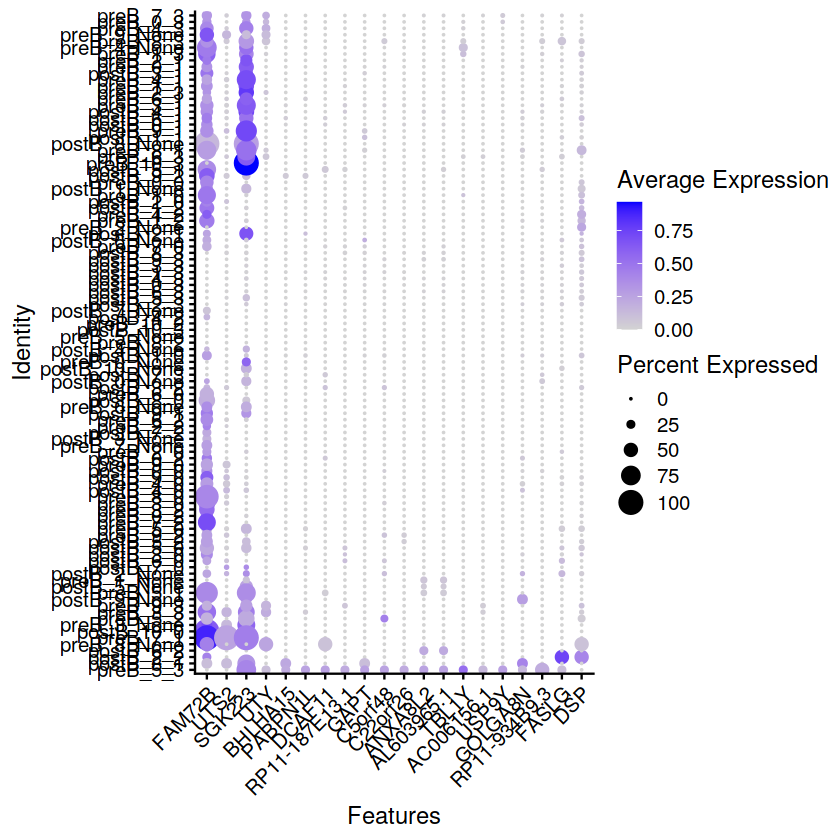

In [8]:
sig.all.ordered <- sort(rowMeans(-log10(all.pvals),na.rm=T), decreasing=T)
dot <- DotPlot(se, scale=FALSE,
               features = head(names(sig.all.ordered),20), 
               cluster.idents=T) + RotatedAxis()
dot

de.plots(se, names(sig.all.ordered), btwnConds_inClust_sepDonrs.outdir, 
         curr.name="allClusters.pvalsOrdered", max.size=20)

### Same features, but dont separate by donors

Saving 6.67 x 6.67 in image



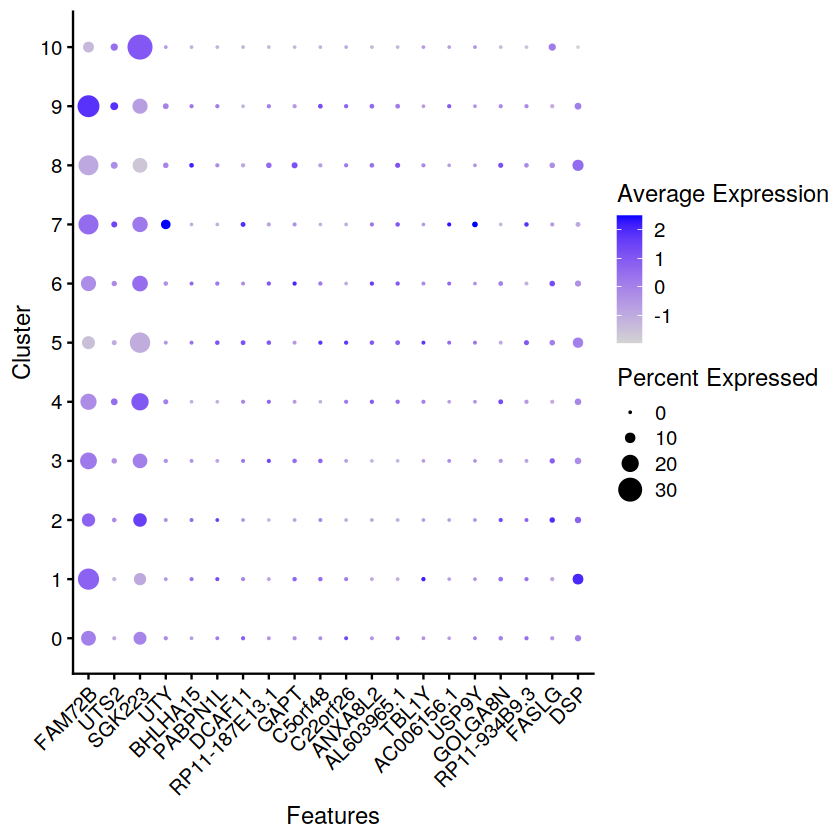

In [9]:
Idents(se)<-se$seurat_clusters
sig.all.ordered <- sort(rowMeans(-log10(all.pvals),na.rm=T), decreasing=T)
dot <- DotPlot(se, scale=T,
               features = head(names(sig.all.ordered),20), 
               cluster.idents=F) + RotatedAxis() + ylab("Cluster")
ggsave(file.path(btwnConds_inClust_sepDonrs.outdir,
                 "allClusters.combineDonorsConds.pvalsOrdered.png"))

dot

,0_0_preB_postB,0_1_preB_postB,0_3_preB_postB,1_0_preB_postB,1_2_preB_postB,1_3_preB_postB,2_1_preB_postB,2_2_preB_postB,2_3_preB_postB,3_0_preB_postB,⋯,4_0_preB_postB,4_1_preB_postB,4_3_preB_postB,5_3_preB_postB,6_0_preB_postB,6_3_preB_postB,7_3_preB_postB,8_3_preB_postB,9_0_preB_postB,9_3_preB_postB
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
PLCXD1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0.000000,0.000000,0.000000,⋯,0,0,0.000000,0,0.000000,0,0,0,0.000000,0
GTPBP6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0.000000,0.000000,0.000000,⋯,0,0,0.000000,0,0.000000,0,0,0,0.000000,0
PPP2R3B,1.033401,0.000000,1.063046,1.444251,0.000000,0.000000,0,0.000000,0.000000,1.416305,⋯,0,0,0.000000,0,0.000000,0,0,0,0.000000,0
SHOX,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0.000000,0.000000,0.000000,⋯,0,0,0.000000,0,0.000000,0,0,0,0.000000,0
CRLF2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0.000000,0.000000,0.000000,⋯,0,0,0.000000,0,0.000000,0,0,0,0.000000,0
CSF2RA,0.000000,1.355076,0.000000,1.138478,0.000000,1.097317,0,0.000000,0.000000,0.000000,⋯,0,0,1.050284,0,1.135696,0,0,0,0.000000,0
IL3RA,0.000000,0.000000,0.000000,0.000000,1.159614,0.000000,0,1.065319,0.000000,0.000000,⋯,0,0,0.000000,0,0.000000,0,0,0,0.000000,0
SLC25A6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0.000000,0.000000,0.000000,⋯,0,0,0.000000,0,0.000000,0,0,0,0.000000,0
ASMTL,0.000000,0.000000,0.000000,0.000000,0.000000,1.059076,0,0.000000,1.551847,0.000000,⋯,0,0,0.000000,0,0.000000,0,0,0,0.000000,0


Saving 6.67 x 6.67 in image



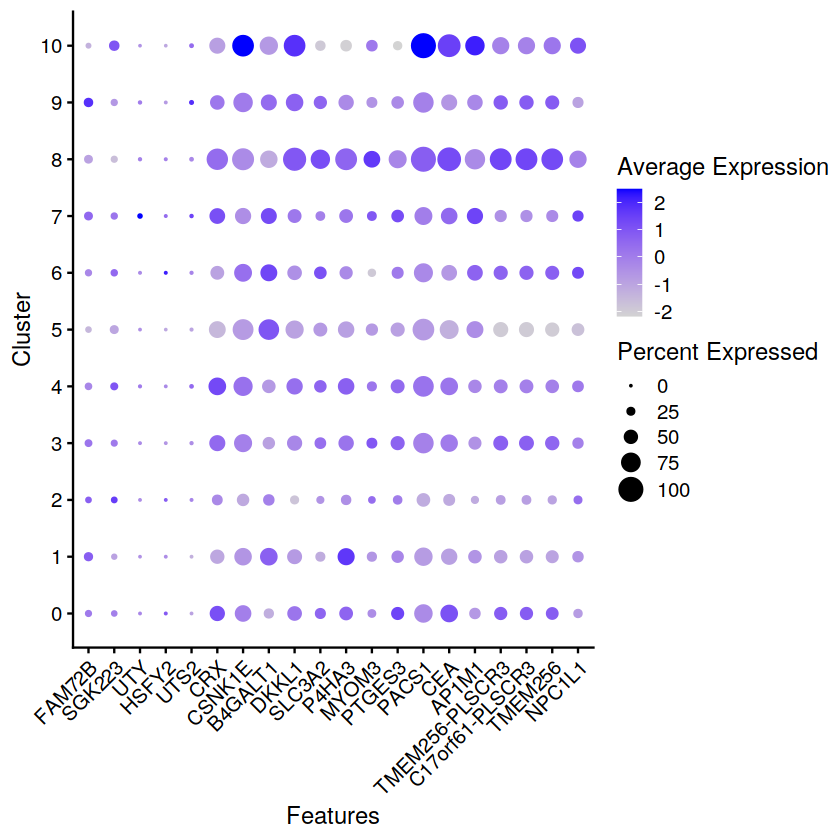

In [10]:
all.pvals.nafill <- all.pvals
all.pvals.nafill[,] <- -log10(zoo::na.fill(all.pvals,1))
all.pvals.nafill

Idents(se)<-se$seurat_clusters
sig.all.ordered <- sort(rowMeans(all.pvals.nafill), decreasing=T)
dot <- DotPlot(se, scale=T,
               features = head(names(sig.all.ordered),20), 
               cluster.idents=F) + RotatedAxis() + ylab("Cluster")
ggsave(file.path(btwnConds_inClust_sepDonrs.outdir,
                 "allClusters.combineDonorsConds.pvalsOrderedNA.png"))

dot

Saving 6.67 x 6.67 in image



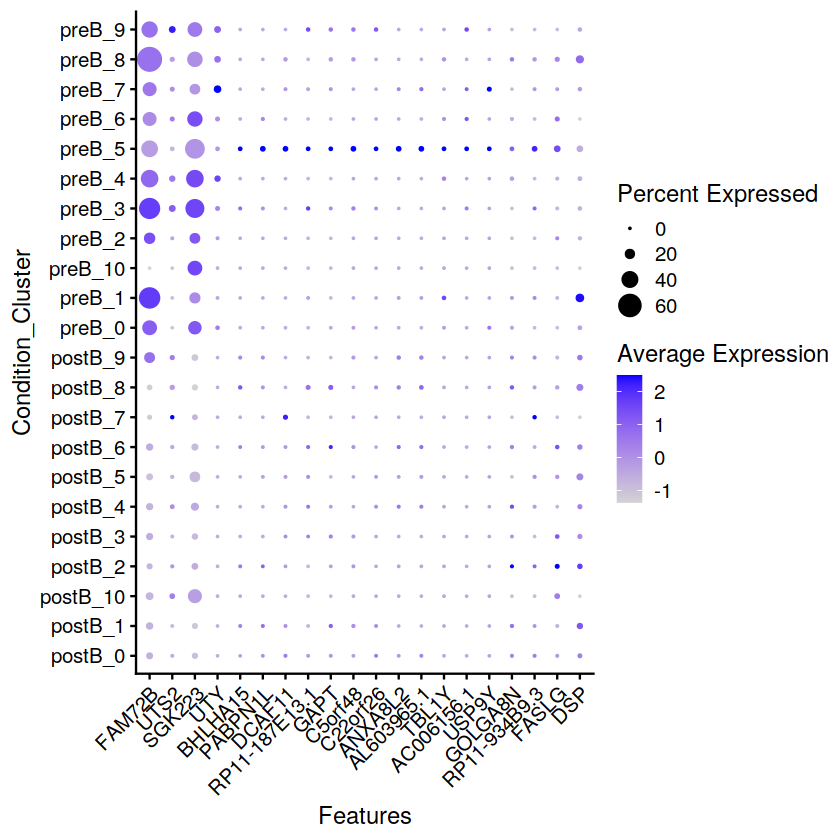

In [11]:
Idents(se)<-se$condition.clust
sig.all.ordered <- sort(rowMeans(-log10(all.pvals),na.rm=T), decreasing=T)
dot <- DotPlot(se, scale=T,
               features = head(names(sig.all.ordered),20), 
               cluster.idents=F) + RotatedAxis() + ylab("Condition_Cluster")
ggsave(file.path(btwnConds_inClust_sepDonrs.outdir, "allClusters.combineDonors.pvalsOrdered.png"))
dot

Saving 6.67 x 6.67 in image



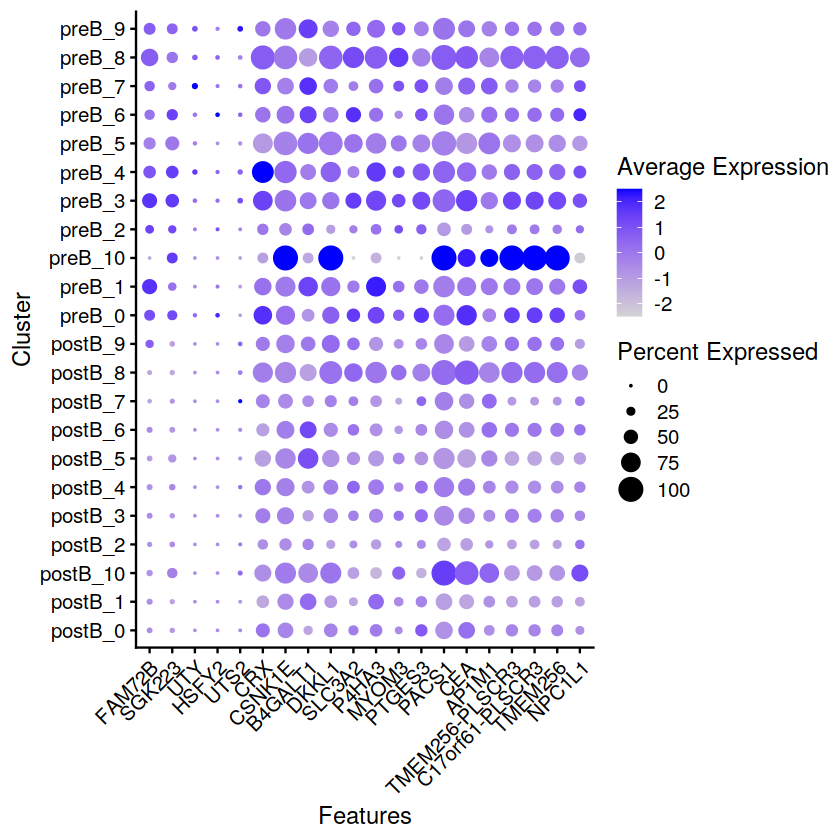

In [12]:
all.pvals.nafill <- all.pvals
all.pvals.nafill[,] <- -log10(zoo::na.fill(all.pvals,1))

Idents(se)<-se$condition.clust
sig.all.ordered <- sort(rowMeans(all.pvals.nafill), decreasing=T)
dot <- DotPlot(se, scale=T,
               features = head(names(sig.all.ordered),20), 
               cluster.idents=F) + RotatedAxis() + ylab("Cluster")
ggsave(file.path(btwnConds_inClust_sepDonrs.outdir,
                 "allClusters.combineDonors.pvalsOrderedNA.png"))

dot

## ii. Taking top 3 of each sig DE

The automatically generated colors map from the 1^st and 99^th of the
values in the matrix. There are outliers in the matrix whose patterns
might be hidden by this color mapping. You can manually set the color
to `col` argument.

Use `suppressMessages()` to turn off this message.

'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



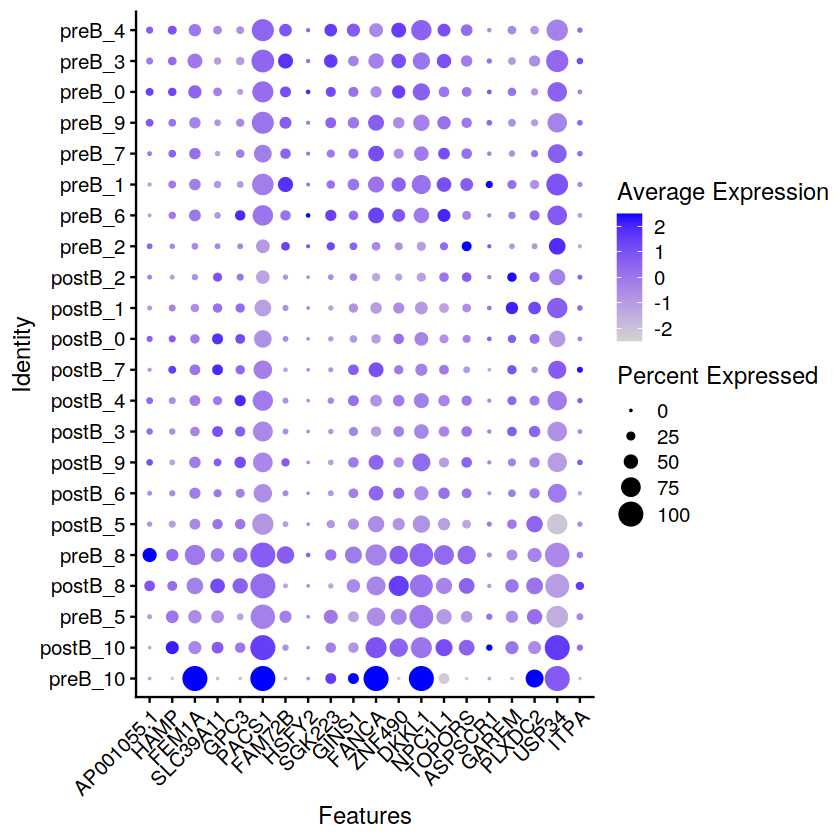

In [13]:
all.names.sig <- unique(all.names.sig)
de.plots(se, all.names.sig, btwnConds_inClust.outdir, curr.name="allDonors.allClusters", max.size=15)

dot <- DotPlot(se, scale=T,
               features = head(all.names.sig,20), 
               cluster.idents=T) + RotatedAxis()
dot
ggsave(file.path(btwnConds_inClust_sepDonrs.outdir, "allClusters.combineDonors.top3de.png"))
ggsave(file.path(btwnConds_inClust_sepDonrs.outdir, "allClusters.combineDonors.top3de.pdf"))

In [14]:
# Get commone DE values
# tfs_nclust_set_de_overlap = {} # for each tf count number of clusters seen with de results in at least 1 donor
# tfs_clust_de = {}

# clust_dirs = glob.glob(cond_indir+"/clust_*")
# clusters = [basename(x).split("_")[-1] for x in clust_dirs]
# #clusters.sort()

# for i in clust_dirs:
#     print("clusert", i)
#     clust = basename(i).split("_")[-1]
    
#     for d in range(n_donors):
#         print("donor", d)
#         curr_dir = join(i, f"donor{d}")
#         curr_f = glob.glob(join(curr_dir, "*DE.csv"))
#         assert(len(curr_f)<=1)
#         if len(curr_f) == 0:
#             print("no file")
#             continue
#         curr_f = curr_f[0]
#         curr_de = pd.read_csv(curr_f,index_col=0)
#         #print('curr_de', curr_de.shape)
#         curr_de = curr_de.loc[curr_de["p_val_adj_BH"] < p_thresh]
#         for tf in curr_de.index:
#             if tf in tfs_nclust_set_de_overlap.keys():
#                 tfs_nclust_set_de_overlap[tf].add(clust)
#                     #tfs_nclust_de_overlap[tf] += 1
#                 tfs_clust_de[tf].append((clust, d))
#             else:
#                 #tfs_nclust_de_overlap[tf] = 1
#                 tfs_nclust_set_de_overlap[tf] = set([clust])
#                 tfs_clust_de[tf] = [(clust,d)]
#         print('curr_de sig', curr_de.shape)



--------

## Stimulus specific response in each cluster, not splitting donors

In [15]:

source(utils_script)

all.pvals <- data.frame(matrix(nrow=dim(se)[1],ncol=0),
                          row.names=row.names(se))
all.names.sig <- c()

#sample_names
cluster.ids <- sort(unique(se$seurat_clusters))
se$celltype.stim <- paste(se$seurat_clusters, se$orig.ident, sep = "_")
se$celltype <- se$seurat_clusters
Idents(se) <- "celltype.stim"

for (curr.clust in cluster.ids){
    ident.1 = paste0(curr.clust, "_", sample_names[[1]]) 
    ident.2 = paste0(curr.clust, "_", sample_names[[2]])
    try({
        print(curr.clust)
        #se.filt <- subset(se, idents = c(ident.1,ident.2))
        #curr.donor = se.filt$donor[[1]] #strsplit(c,"_")[[2]]
        curr.name <-paste0("clust_", curr.clust)
        curr.clust.outdir <- file.path(btwnConds_inClust.outdir, paste0("clust_", curr.clust))
        dir.create(curr.clust.outdir)

        curr.sig <- find.markers.and.plot(se, ident.1, ident.2, curr.clust.outdir, curr.name=curr.clust, 
                              min.pct=minPct, p.thresh=p_thresh,latent.var=latent.vars, test.use=test.use)
        names.sig <- rownames(curr.sig)
        all.names.sig <- c(all.names.sig, head(names.sig, top_de))
        
        all.pvals[names.sig,curr.clust] <- curr.sig$p_val_adj_BH

        curr_clust <- subset(se, seurat_clusters == curr.clust)
        avg_curr_clust <- data.frame(log1p(AverageExpression(curr_clust, verbose = FALSE)$RNA))
        avg_curr_clust$gene <- rownames(avg_curr_clust)
        p1 <- ggplot(avg_curr_clust, aes_string(paste0("X", c, "_", sample_names[[1]]), 
                                                paste0("X", c, "_", sample_names[[2]]))) + geom_point() + ggtitle(paste("Cluster", curr.clust))
        p1 <- LabelPoints(plot = p1, points = names.sig, repel = TRUE)
        plot_grid(p1)
        #write.csv(response, file=file.path(curr.clust.outdir,paste0("cluster_",c,".conditionDE.csv")))
        ggsave(file.path(curr.clust.outdir,paste0("cluster_",curr.clust,".allDonors.conditionScatter.png")))
        
        })
    }
     



[1] "0"


Warning message in dir.create(curr.clust.outdir):
"'/data/Mito_Trace/output/pipeline/DUPI_april08_2021/MTblacklist_mtasnucl_Bonly/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_3/concat/annotation_clones/genes_donors_DE_minPct_00/btwnConds_inClust/clust_0' already exists"


[1] "curr sig"
                p_val  avg_diff pct.1 pct.2    p_val_adj p_val_adj_BH
SGK223   1.009781e-15 0.2065791 0.294 0.078 2.020572e-11 5.634579e-13
FAM72B   5.168800e-15 0.1837399 0.336 0.101 1.034277e-10 1.442095e-12
ADCY7    6.667218e-12 0.1741845 0.374 0.149 1.334110e-07 1.240102e-09
ZDHHC24  2.170139e-11 0.2755867 0.692 0.440 4.342447e-07 3.027343e-09
TBC1D10B 5.586717e-09 0.2660146 0.715 0.523 1.117902e-04 6.234776e-07
WRNIP1   7.092246e-09 0.1641970 0.458 0.241 1.419158e-04 6.595788e-07
[1] "dim response"
[1] 558   6
[1] "response plots"
                p_val  avg_diff pct.1 pct.2    p_val_adj p_val_adj_BH
SGK223   1.009781e-15 0.2065791 0.294 0.078 2.020572e-11 5.634579e-13
FAM72B   5.168800e-15 0.1837399 0.336 0.101 1.034277e-10 1.442095e-12
ADCY7    6.667218e-12 0.1741845 0.374 0.149 1.334110e-07 1.240102e-09
ZDHHC24  2.170139e-11 0.2755867 0.692 0.440 4.342447e-07 3.027343e-09
TBC1D10B 5.586717e-09 0.2660146 0.715 0.523 1.117902e-04 6.234776e-07
WRNIP1   7.092246e-09 0

'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



                p_val  avg_diff pct.1 pct.2    p_val_adj p_val_adj_BH
SGK223   1.009781e-15 0.2065791 0.294 0.078 2.020572e-11 5.634579e-13
FAM72B   5.168800e-15 0.1837399 0.336 0.101 1.034277e-10 1.442095e-12
ADCY7    6.667218e-12 0.1741845 0.374 0.149 1.334110e-07 1.240102e-09
ZDHHC24  2.170139e-11 0.2755867 0.692 0.440 4.342447e-07 3.027343e-09
TBC1D10B 5.586717e-09 0.2660146 0.715 0.523 1.117902e-04 6.234776e-07
WRNIP1   7.092246e-09 0.1641970 0.458 0.241 1.419158e-04 6.595788e-07


Saving 6.67 x 6.67 in image

When using repel, set xnudge and ynudge to 0 for optimal results



Error in FUN(X[[i]], ...) : object 'X10_3_preB' not found
[1] "1"


Warning message in dir.create(curr.clust.outdir):
"'/data/Mito_Trace/output/pipeline/DUPI_april08_2021/MTblacklist_mtasnucl_Bonly/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_3/concat/annotation_clones/genes_donors_DE_minPct_00/btwnConds_inClust/clust_1' already exists"


[1] "curr sig"
              p_val  avg_diff pct.1 pct.2    p_val_adj p_val_adj_BH
FAM72B 2.795641e-26 0.2886384 0.536 0.113 5.594079e-22 1.557172e-23
DKKL1  1.407913e-12 0.2676972 0.724 0.425 2.817233e-08 3.921037e-10
KANSL1 2.170195e-10 0.2876558 0.816 0.565 4.342561e-06 4.029330e-08
AKT2   4.442251e-10 0.2571517 0.770 0.524 8.888943e-06 6.185834e-08
AP1M1  1.770435e-09 0.2102795 0.628 0.374 3.542640e-05 1.972264e-07
FTL    2.570630e-09 0.1373474 0.362 0.151 5.143830e-05 2.149483e-07
[1] "dim response"
[1] 557   6
[1] "response plots"
              p_val  avg_diff pct.1 pct.2    p_val_adj p_val_adj_BH
FAM72B 2.795641e-26 0.2886384 0.536 0.113 5.594079e-22 1.557172e-23
DKKL1  1.407913e-12 0.2676972 0.724 0.425 2.817233e-08 3.921037e-10
KANSL1 2.170195e-10 0.2876558 0.816 0.565 4.342561e-06 4.029330e-08
AKT2   4.442251e-10 0.2571517 0.770 0.524 8.888943e-06 6.185834e-08
AP1M1  1.770435e-09 0.2102795 0.628 0.374 3.542640e-05 1.972264e-07
FTL    2.570630e-09 0.1373474 0.362 0.151 5.14383

'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



              p_val  avg_diff pct.1 pct.2    p_val_adj p_val_adj_BH
FAM72B 2.795641e-26 0.2886384 0.536 0.113 5.594079e-22 1.557172e-23
DKKL1  1.407913e-12 0.2676972 0.724 0.425 2.817233e-08 3.921037e-10
KANSL1 2.170195e-10 0.2876558 0.816 0.565 4.342561e-06 4.029330e-08
AKT2   4.442251e-10 0.2571517 0.770 0.524 8.888943e-06 6.185834e-08
AP1M1  1.770435e-09 0.2102795 0.628 0.374 3.542640e-05 1.972264e-07
FTL    2.570630e-09 0.1373474 0.362 0.151 5.143830e-05 2.149483e-07


Saving 6.67 x 6.67 in image

When using repel, set xnudge and ynudge to 0 for optimal results



Error in FUN(X[[i]], ...) : object 'X10_3_preB' not found
[1] "2"


Warning message in dir.create(curr.clust.outdir):
"'/data/Mito_Trace/output/pipeline/DUPI_april08_2021/MTblacklist_mtasnucl_Bonly/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_3/concat/annotation_clones/genes_donors_DE_minPct_00/btwnConds_inClust/clust_2' already exists"


[1] "curr sig"
              p_val   avg_diff pct.1 pct.2    p_val_adj p_val_adj_BH
ASTN1  4.334168e-08 -0.1347049 0.023 0.182 0.0008672671 1.285875e-05
THRB   1.062652e-07 -0.1752683 0.060 0.231 0.0021263659 1.285875e-05
DACH1  1.633000e-07 -0.1772648 0.102 0.301 0.0032676326 1.285875e-05
FAM13A 1.669968e-07 -0.2338644 0.139 0.343 0.0033416051 1.285875e-05
FAM72B 2.123826e-07  0.1842891 0.231 0.073 0.0042497751 1.308277e-05
PLXDC2 3.493731e-07 -0.1699094 0.106 0.297 0.0069909559 1.793449e-05
[1] "dim response"
[1] 308   6
[1] "response plots"
              p_val   avg_diff pct.1 pct.2    p_val_adj p_val_adj_BH
ASTN1  4.334168e-08 -0.1347049 0.023 0.182 0.0008672671 1.285875e-05
THRB   1.062652e-07 -0.1752683 0.060 0.231 0.0021263659 1.285875e-05
DACH1  1.633000e-07 -0.1772648 0.102 0.301 0.0032676326 1.285875e-05
FAM13A 1.669968e-07 -0.2338644 0.139 0.343 0.0033416051 1.285875e-05
FAM72B 2.123826e-07  0.1842891 0.231 0.073 0.0042497751 1.308277e-05
PLXDC2 3.493731e-07 -0.1699094 0.106

'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



              p_val   avg_diff pct.1 pct.2    p_val_adj p_val_adj_BH
ASTN1  4.334168e-08 -0.1347049 0.023 0.182 0.0008672671 1.285875e-05
THRB   1.062652e-07 -0.1752683 0.060 0.231 0.0021263659 1.285875e-05
DACH1  1.633000e-07 -0.1772648 0.102 0.301 0.0032676326 1.285875e-05
FAM13A 1.669968e-07 -0.2338644 0.139 0.343 0.0033416051 1.285875e-05
FAM72B 2.123826e-07  0.1842891 0.231 0.073 0.0042497751 1.308277e-05
PLXDC2 3.493731e-07 -0.1699094 0.106 0.297 0.0069909559 1.793449e-05


Saving 6.67 x 6.67 in image

When using repel, set xnudge and ynudge to 0 for optimal results



Error in FUN(X[[i]], ...) : object 'X10_3_preB' not found
[1] "3"


Warning message in dir.create(curr.clust.outdir):
"'/data/Mito_Trace/output/pipeline/DUPI_april08_2021/MTblacklist_mtasnucl_Bonly/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_3/concat/annotation_clones/genes_donors_DE_minPct_00/btwnConds_inClust/clust_3' already exists"


[1] "curr sig"
              p_val  avg_diff pct.1 pct.2    p_val_adj p_val_adj_BH
FAM72B 1.467740e-20 0.2707127 0.529 0.105 2.936948e-16 9.437568e-18
SGK223 8.953562e-20 0.2676189 0.462 0.082 1.791608e-15 2.878570e-17
FMOD   9.177729e-10 0.1097048 0.288 0.069 1.836464e-05 1.967093e-07
ADCY7  1.376534e-08 0.2396653 0.510 0.235 2.754445e-04 2.212779e-06
TRIM66 4.116543e-08 0.1486477 0.452 0.179 8.237203e-04 5.293874e-06
RRN3   1.053821e-07 0.1123211 0.327 0.107 2.108696e-03 1.129345e-05
[1] "dim response"
[1] 643   6
[1] "response plots"
              p_val  avg_diff pct.1 pct.2    p_val_adj p_val_adj_BH
FAM72B 1.467740e-20 0.2707127 0.529 0.105 2.936948e-16 9.437568e-18
SGK223 8.953562e-20 0.2676189 0.462 0.082 1.791608e-15 2.878570e-17
FMOD   9.177729e-10 0.1097048 0.288 0.069 1.836464e-05 1.967093e-07
ADCY7  1.376534e-08 0.2396653 0.510 0.235 2.754445e-04 2.212779e-06
TRIM66 4.116543e-08 0.1486477 0.452 0.179 8.237203e-04 5.293874e-06
RRN3   1.053821e-07 0.1123211 0.327 0.107 2.10869

'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



              p_val  avg_diff pct.1 pct.2    p_val_adj p_val_adj_BH
FAM72B 1.467740e-20 0.2707127 0.529 0.105 2.936948e-16 9.437568e-18
SGK223 8.953562e-20 0.2676189 0.462 0.082 1.791608e-15 2.878570e-17
FMOD   9.177729e-10 0.1097048 0.288 0.069 1.836464e-05 1.967093e-07
ADCY7  1.376534e-08 0.2396653 0.510 0.235 2.754445e-04 2.212779e-06
TRIM66 4.116543e-08 0.1486477 0.452 0.179 8.237203e-04 5.293874e-06
RRN3   1.053821e-07 0.1123211 0.327 0.107 2.108696e-03 1.129345e-05


Saving 6.67 x 6.67 in image

When using repel, set xnudge and ynudge to 0 for optimal results



Error in FUN(X[[i]], ...) : object 'X10_3_preB' not found
[1] "4"


Warning message in dir.create(curr.clust.outdir):
"'/data/Mito_Trace/output/pipeline/DUPI_april08_2021/MTblacklist_mtasnucl_Bonly/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_3/concat/annotation_clones/genes_donors_DE_minPct_00/btwnConds_inClust/clust_4' already exists"


[1] "curr sig"
                  p_val  avg_diff pct.1 pct.2    p_val_adj p_val_adj_BH
FAM72B     5.055241e-10 0.1897767 0.419 0.109 1.011554e-05 2.967426e-07
SGK223     1.247548e-08 0.2156636 0.419 0.131 2.496343e-04 2.747445e-06
NBPF1      1.404146e-08 0.3239005 0.767 0.438 2.809696e-04 2.747445e-06
MTHFS      1.889330e-07 0.1469778 0.372 0.124 3.780549e-03 2.494316e-05
ST20-MTHFS 2.124631e-07 0.1579752 0.384 0.135 4.251386e-03 2.494316e-05
CRX        1.081863e-06 0.2986830 0.849 0.592 2.164808e-02 1.058423e-04
[1] "dim response"
[1] 587   6
[1] "response plots"
                  p_val  avg_diff pct.1 pct.2    p_val_adj p_val_adj_BH
FAM72B     5.055241e-10 0.1897767 0.419 0.109 1.011554e-05 2.967426e-07
SGK223     1.247548e-08 0.2156636 0.419 0.131 2.496343e-04 2.747445e-06
NBPF1      1.404146e-08 0.3239005 0.767 0.438 2.809696e-04 2.747445e-06
MTHFS      1.889330e-07 0.1469778 0.372 0.124 3.780549e-03 2.494316e-05
ST20-MTHFS 2.124631e-07 0.1579752 0.384 0.135 4.251386e-03 2.494316e-

The automatically generated colors map from the 1^st and 99^th of the
values in the matrix. There are outliers in the matrix whose patterns
might be hidden by this color mapping. You can manually set the color
to `col` argument.

Use `suppressMessages()` to turn off this message.

'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



                  p_val  avg_diff pct.1 pct.2    p_val_adj p_val_adj_BH
FAM72B     5.055241e-10 0.1897767 0.419 0.109 1.011554e-05 2.967426e-07
SGK223     1.247548e-08 0.2156636 0.419 0.131 2.496343e-04 2.747445e-06
NBPF1      1.404146e-08 0.3239005 0.767 0.438 2.809696e-04 2.747445e-06
MTHFS      1.889330e-07 0.1469778 0.372 0.124 3.780549e-03 2.494316e-05
ST20-MTHFS 2.124631e-07 0.1579752 0.384 0.135 4.251386e-03 2.494316e-05
CRX        1.081863e-06 0.2986830 0.849 0.592 2.164808e-02 1.058423e-04


Saving 6.67 x 6.67 in image

When using repel, set xnudge and ynudge to 0 for optimal results



Error in FUN(X[[i]], ...) : object 'X10_3_preB' not found
[1] "5"


Warning message in dir.create(curr.clust.outdir):
"'/data/Mito_Trace/output/pipeline/DUPI_april08_2021/MTblacklist_mtasnucl_Bonly/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_3/concat/annotation_clones/genes_donors_DE_minPct_00/btwnConds_inClust/clust_5' already exists"


[1] "curr sig"
              p_val  avg_diff pct.1 pct.2   p_val_adj p_val_adj_BH
RAMP2  3.130026e-07 0.1143360 0.364 0.068 0.006263182 0.0001699604
FAM72B 1.217304e-05 0.1095662 0.394 0.099 0.243582521 0.0020937191
NLRP12 1.504316e-05 0.2089105 0.636 0.279 0.301013690 0.0020937191
ZNF578 2.320111e-05 0.1664873 0.455 0.140 0.464254125 0.0020937191
TM7SF2 2.430914e-05 0.2207159 0.667 0.320 0.486425967 0.0020937191
FBXO44 2.952327e-05 0.1012886 0.394 0.108 0.590760566 0.0020937191
[1] "dim response"
[1] 543   6
[1] "response plots"
              p_val  avg_diff pct.1 pct.2   p_val_adj p_val_adj_BH
RAMP2  3.130026e-07 0.1143360 0.364 0.068 0.006263182 0.0001699604
FAM72B 1.217304e-05 0.1095662 0.394 0.099 0.243582521 0.0020937191
NLRP12 1.504316e-05 0.2089105 0.636 0.279 0.301013690 0.0020937191
ZNF578 2.320111e-05 0.1664873 0.455 0.140 0.464254125 0.0020937191
TM7SF2 2.430914e-05 0.2207159 0.667 0.320 0.486425967 0.0020937191
FBXO44 2.952327e-05 0.1012886 0.394 0.108 0.590760566 0.002093

The automatically generated colors map from the 1^st and 99^th of the
values in the matrix. There are outliers in the matrix whose patterns
might be hidden by this color mapping. You can manually set the color
to `col` argument.

Use `suppressMessages()` to turn off this message.

'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



              p_val  avg_diff pct.1 pct.2   p_val_adj p_val_adj_BH
RAMP2  3.130026e-07 0.1143360 0.364 0.068 0.006263182 0.0001699604
FAM72B 1.217304e-05 0.1095662 0.394 0.099 0.243582521 0.0020937191
NLRP12 1.504316e-05 0.2089105 0.636 0.279 0.301013690 0.0020937191
ZNF578 2.320111e-05 0.1664873 0.455 0.140 0.464254125 0.0020937191
TM7SF2 2.430914e-05 0.2207159 0.667 0.320 0.486425967 0.0020937191
FBXO44 2.952327e-05 0.1012886 0.394 0.108 0.590760566 0.0020937191


Saving 6.67 x 6.67 in image

When using repel, set xnudge and ynudge to 0 for optimal results



Error in FUN(X[[i]], ...) : object 'X10_3_preB' not found
[1] "6"


Warning message in dir.create(curr.clust.outdir):
"'/data/Mito_Trace/output/pipeline/DUPI_april08_2021/MTblacklist_mtasnucl_Bonly/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_3/concat/annotation_clones/genes_donors_DE_minPct_00/btwnConds_inClust/clust_6' already exists"


[1] "curr sig"
               p_val   avg_diff pct.1 pct.2  p_val_adj p_val_adj_BH
SGK223  1.755002e-06  0.2173397 0.351 0.103 0.03511758 0.0007581607
DGKQ    1.610129e-05  0.2173372 0.446 0.194 0.32218676 0.0034778780
ALDH3B2 8.876016e-05  0.1720557 0.351 0.143 1.00000000 0.0127814625
CACNB4  2.592619e-04 -0.2297604 0.392 0.617 1.00000000 0.0224781973
GABRB2  2.799889e-04 -0.1248103 0.014 0.183 1.00000000 0.0224781973
GLRA1   3.628936e-04  0.2895559 0.730 0.560 1.00000000 0.0224781973
[1] "dim response"
[1] 432   6
[1] "response plots"
               p_val   avg_diff pct.1 pct.2  p_val_adj p_val_adj_BH
SGK223  1.755002e-06  0.2173397 0.351 0.103 0.03511758 0.0007581607
DGKQ    1.610129e-05  0.2173372 0.446 0.194 0.32218676 0.0034778780
ALDH3B2 8.876016e-05  0.1720557 0.351 0.143 1.00000000 0.0127814625
CACNB4  2.592619e-04 -0.2297604 0.392 0.617 1.00000000 0.0224781973
GABRB2  2.799889e-04 -0.1248103 0.014 0.183 1.00000000 0.0224781973
GLRA1   3.628936e-04  0.2895559 0.730 0.560 1.000

'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



               p_val   avg_diff pct.1 pct.2  p_val_adj p_val_adj_BH
SGK223  1.755002e-06  0.2173397 0.351 0.103 0.03511758 0.0007581607
DGKQ    1.610129e-05  0.2173372 0.446 0.194 0.32218676 0.0034778780
ALDH3B2 8.876016e-05  0.1720557 0.351 0.143 1.00000000 0.0127814625
CACNB4  2.592619e-04 -0.2297604 0.392 0.617 1.00000000 0.0224781973
GABRB2  2.799889e-04 -0.1248103 0.014 0.183 1.00000000 0.0224781973
GLRA1   3.628936e-04  0.2895559 0.730 0.560 1.00000000 0.0224781973


Saving 6.67 x 6.67 in image

When using repel, set xnudge and ynudge to 0 for optimal results



Error in FUN(X[[i]], ...) : object 'X10_3_preB' not found
[1] "7"


Warning message in dir.create(curr.clust.outdir):
"'/data/Mito_Trace/output/pipeline/DUPI_april08_2021/MTblacklist_mtasnucl_Bonly/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_3/concat/annotation_clones/genes_donors_DE_minPct_00/btwnConds_inClust/clust_7' already exists"


[1] "curr sig"
                 p_val   avg_diff pct.1 pct.2 p_val_adj p_val_adj_BH
QTRTD1    6.883430e-06  0.4108737 0.586 0.217 0.1377374  0.005064418
SKIV2L2   1.135610e-05  0.3230703 0.453 0.087 0.2272356  0.005064418
C20orf112 1.486620e-05 -0.2358649 0.023 0.217 0.2974726  0.005064418
ACACA     4.854393e-05  0.4551450 0.773 0.435 0.9713640  0.010724045
SLC39A11  5.246597e-05 -0.2335518 0.086 0.326 1.0000000  0.010724045
PRRX1     6.683148e-05 -0.1263266 0.008 0.152 1.0000000  0.011383629
[1] "dim response"
[1] 1022    6
[1] "response plots"
                 p_val   avg_diff pct.1 pct.2 p_val_adj p_val_adj_BH
QTRTD1    6.883430e-06  0.4108737 0.586 0.217 0.1377374  0.005064418
SKIV2L2   1.135610e-05  0.3230703 0.453 0.087 0.2272356  0.005064418
C20orf112 1.486620e-05 -0.2358649 0.023 0.217 0.2974726  0.005064418
ACACA     4.854393e-05  0.4551450 0.773 0.435 0.9713640  0.010724045
SLC39A11  5.246597e-05 -0.2335518 0.086 0.326 1.0000000  0.010724045
PRRX1     6.683148e-05 -0.1263266 

The automatically generated colors map from the 1^st and 99^th of the
values in the matrix. There are outliers in the matrix whose patterns
might be hidden by this color mapping. You can manually set the color
to `col` argument.

Use `suppressMessages()` to turn off this message.

'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



                 p_val   avg_diff pct.1 pct.2 p_val_adj p_val_adj_BH
QTRTD1    6.883430e-06  0.4108737 0.586 0.217 0.1377374  0.005064418
SKIV2L2   1.135610e-05  0.3230703 0.453 0.087 0.2272356  0.005064418
C20orf112 1.486620e-05 -0.2358649 0.023 0.217 0.2974726  0.005064418
ACACA     4.854393e-05  0.4551450 0.773 0.435 0.9713640  0.010724045
SLC39A11  5.246597e-05 -0.2335518 0.086 0.326 1.0000000  0.010724045
PRRX1     6.683148e-05 -0.1263266 0.008 0.152 1.0000000  0.011383629


Saving 6.67 x 6.67 in image

When using repel, set xnudge and ynudge to 0 for optimal results



Error in FUN(X[[i]], ...) : object 'X10_3_preB' not found
[1] "8"


Warning message in dir.create(curr.clust.outdir):
"'/data/Mito_Trace/output/pipeline/DUPI_april08_2021/MTblacklist_mtasnucl_Bonly/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_3/concat/annotation_clones/genes_donors_DE_minPct_00/btwnConds_inClust/clust_8' already exists"


[1] "curr sig"
              p_val  avg_diff pct.1 pct.2    p_val_adj p_val_adj_BH
FAM72B 7.398152e-15 0.2671755 0.644 0.059 1.480370e-10 2.360011e-12
NBPF1  6.664480e-07 0.3015950 1.000 0.832 1.333562e-02 1.062984e-04
STAB1  1.344047e-05 0.2099446 0.800 0.436 2.689438e-01 1.150827e-03
SGK223 1.443044e-05 0.1720547 0.356 0.079 2.887531e-01 1.150827e-03
TRPM4  6.476309e-05 0.2486268 0.978 0.713 1.000000e+00 3.872463e-03
LIN9   7.283630e-05 0.1589305 0.622 0.257 1.000000e+00 3.872463e-03
[1] "dim response"
[1] 319   6
[1] "response plots"
              p_val  avg_diff pct.1 pct.2    p_val_adj p_val_adj_BH
FAM72B 7.398152e-15 0.2671755 0.644 0.059 1.480370e-10 2.360011e-12
NBPF1  6.664480e-07 0.3015950 1.000 0.832 1.333562e-02 1.062984e-04
STAB1  1.344047e-05 0.2099446 0.800 0.436 2.689438e-01 1.150827e-03
SGK223 1.443044e-05 0.1720547 0.356 0.079 2.887531e-01 1.150827e-03
TRPM4  6.476309e-05 0.2486268 0.978 0.713 1.000000e+00 3.872463e-03
LIN9   7.283630e-05 0.1589305 0.622 0.257 1.00000

'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



              p_val  avg_diff pct.1 pct.2    p_val_adj p_val_adj_BH
FAM72B 7.398152e-15 0.2671755 0.644 0.059 1.480370e-10 2.360011e-12
NBPF1  6.664480e-07 0.3015950 1.000 0.832 1.333562e-02 1.062984e-04
STAB1  1.344047e-05 0.2099446 0.800 0.436 2.689438e-01 1.150827e-03
SGK223 1.443044e-05 0.1720547 0.356 0.079 2.887531e-01 1.150827e-03
TRPM4  6.476309e-05 0.2486268 0.978 0.713 1.000000e+00 3.872463e-03
LIN9   7.283630e-05 0.1589305 0.622 0.257 1.000000e+00 3.872463e-03


Saving 6.67 x 6.67 in image

When using repel, set xnudge and ynudge to 0 for optimal results



Error in FUN(X[[i]], ...) : object 'X10_3_preB' not found
[1] "9"


Warning message in dir.create(curr.clust.outdir):
"'/data/Mito_Trace/output/pipeline/DUPI_april08_2021/MTblacklist_mtasnucl_Bonly/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_3/concat/annotation_clones/genes_donors_DE_minPct_00/btwnConds_inClust/clust_9' already exists"


[1] "curr sig"
              p_val   avg_diff pct.1 pct.2 p_val_adj p_val_adj_BH
MIPOL1 0.0000582372 -0.2321198 0.071 0.409         1   0.03083415
PARP3  0.0001182643  0.1630739 0.333 0.068         1   0.03083415
PLCH2  0.0001365436  0.2538406 0.595 0.284         1   0.03083415
ARMC1  0.0001566334  0.2086795 0.524 0.193         1   0.03083415
ADCY7  0.0002013545  0.2110380 0.500 0.182         1   0.03083415
NPTXR  0.0002308551  0.1477848 0.310 0.068         1   0.03083415
[1] "dim response"
[1] 1028    6
[1] "response plots"
              p_val   avg_diff pct.1 pct.2 p_val_adj p_val_adj_BH
MIPOL1 0.0000582372 -0.2321198 0.071 0.409         1   0.03083415
PARP3  0.0001182643  0.1630739 0.333 0.068         1   0.03083415
PLCH2  0.0001365436  0.2538406 0.595 0.284         1   0.03083415
ARMC1  0.0001566334  0.2086795 0.524 0.193         1   0.03083415
ADCY7  0.0002013545  0.2110380 0.500 0.182         1   0.03083415
NPTXR  0.0002308551  0.1477848 0.310 0.068         1   0.03083415
[1] "MI

'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



              p_val   avg_diff pct.1 pct.2 p_val_adj p_val_adj_BH
MIPOL1 0.0000582372 -0.2321198 0.071 0.409         1   0.03083415
PARP3  0.0001182643  0.1630739 0.333 0.068         1   0.03083415
PLCH2  0.0001365436  0.2538406 0.595 0.284         1   0.03083415
ARMC1  0.0001566334  0.2086795 0.524 0.193         1   0.03083415
ADCY7  0.0002013545  0.2110380 0.500 0.182         1   0.03083415
NPTXR  0.0002308551  0.1477848 0.310 0.068         1   0.03083415


Saving 6.67 x 6.67 in image

Warning message in cor(x, y):
"the standard deviation is zero"
Warning message in cor(x, y):
"the standard deviation is zero"
Warning message in cor(x, y):
"the standard deviation is zero"
When using repel, set xnudge and ynudge to 0 for optimal results



Error in FUN(X[[i]], ...) : object 'X10_3_preB' not found
[1] "10"


Warning message in dir.create(curr.clust.outdir):
"'/data/Mito_Trace/output/pipeline/DUPI_april08_2021/MTblacklist_mtasnucl_Bonly/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_3/concat/annotation_clones/genes_donors_DE_minPct_00/btwnConds_inClust/clust_10' already exists"


[1] "curr sig"
[1] p_val        avg_diff     pct.1        pct.2        p_val_adj   
[6] p_val_adj_BH
<0 rows> (or 0-length row.names)
[1] "dim response"
[1] 4851    6
[1] "response plots"
              p_val  avg_diff pct.1 pct.2 p_val_adj p_val_adj_BH
METTL9 0.0007003143 0.9990208 1.000 0.125         1    0.4844033
CEP85  0.0011515238 0.6288335 0.667 0.000         1    0.4844033
STK38  0.0011515238 0.5571435 0.667 0.000         1    0.4844033
NCK1   0.0011515238 0.4109472 0.667 0.000         1    0.4844033
GMNC   0.0011515238 0.6505731 0.667 0.000         1    0.4844033
SEZ6L2 0.0011515238 0.4109472 0.667 0.000         1    0.4844033
character(0)
Error in FetchData(object = object, vars = features, cells = cells) : 
  None of the requested variables were found: 


## DE sig summarize

### a) top 3 significant results from each comparison

The automatically generated colors map from the 1^st and 99^th of the
values in the matrix. There are outliers in the matrix whose patterns
might be hidden by this color mapping. You can manually set the color
to `col` argument.

Use `suppressMessages()` to turn off this message.

'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



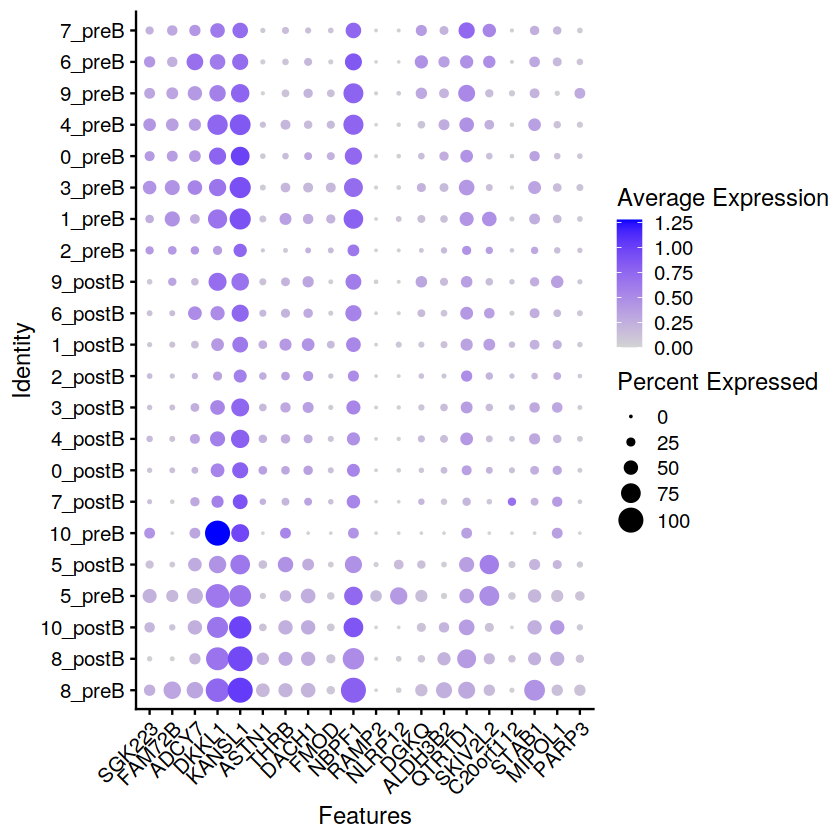

In [16]:
all.names.sig <- unique(all.names.sig)
de.plots(se, all.names.sig, btwnConds_inClust.outdir, curr.name="allDonors.allClusters", max.size=15)

dot <- DotPlot(se, scale=FALSE,
               features = head(all.names.sig,20), 
               cluster.idents=T) + RotatedAxis()
dot
ggsave(file.path(btwnConds_inClust.outdir, "allDonors.allClusters.top3de.png"))
ggsave(file.path(btwnConds_inClust.outdir, "allDonors.allClusters.top3de.pdf"))

## b) averaged top p-values (only average ones that were DE)

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



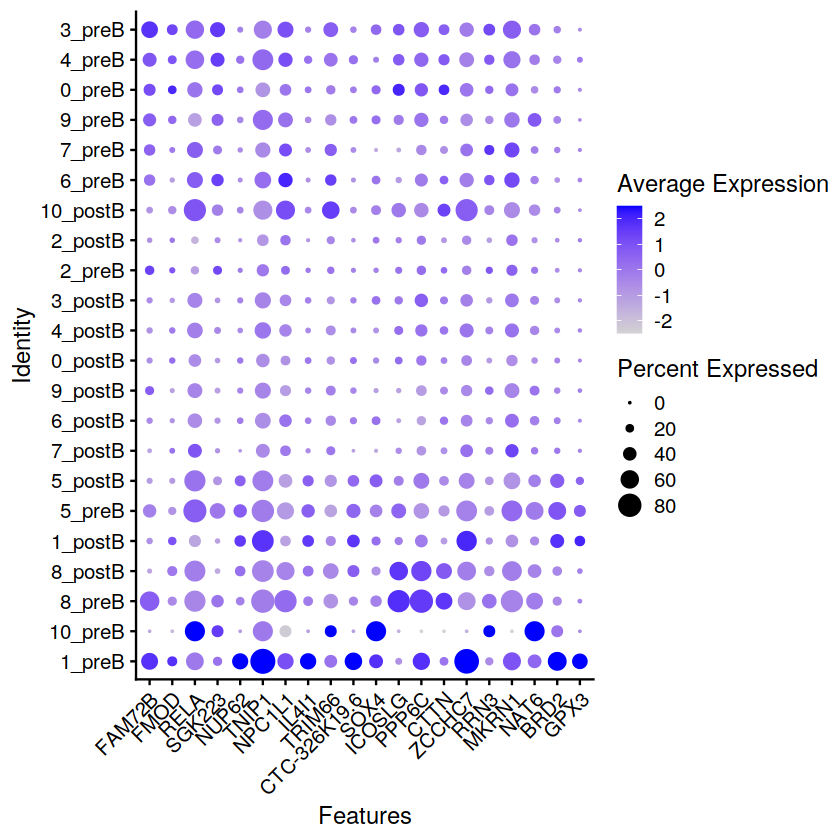

In [17]:
sig.all.ordered <- sort(rowMeans(-log10(all.pvals),na.rm=T), decreasing=T)
dot <- DotPlot(se, scale=T,
               features = names(head(sig.all.ordered,20)), 
               cluster.idents=T) + RotatedAxis()
dot
ggsave(file.path(btwnConds_inClust.outdir, "allDonors.allClusters.pvalsOrdered.png"))
ggsave(file.path(btwnConds_inClust.outdir, "allDonors.allClusters.pvalsOrdered.pdf"))
#de.plots(se, names(sig.all.ordered), outdir, curr.name="allDonors.allClusters.pvalsOrdered", max.size=20)

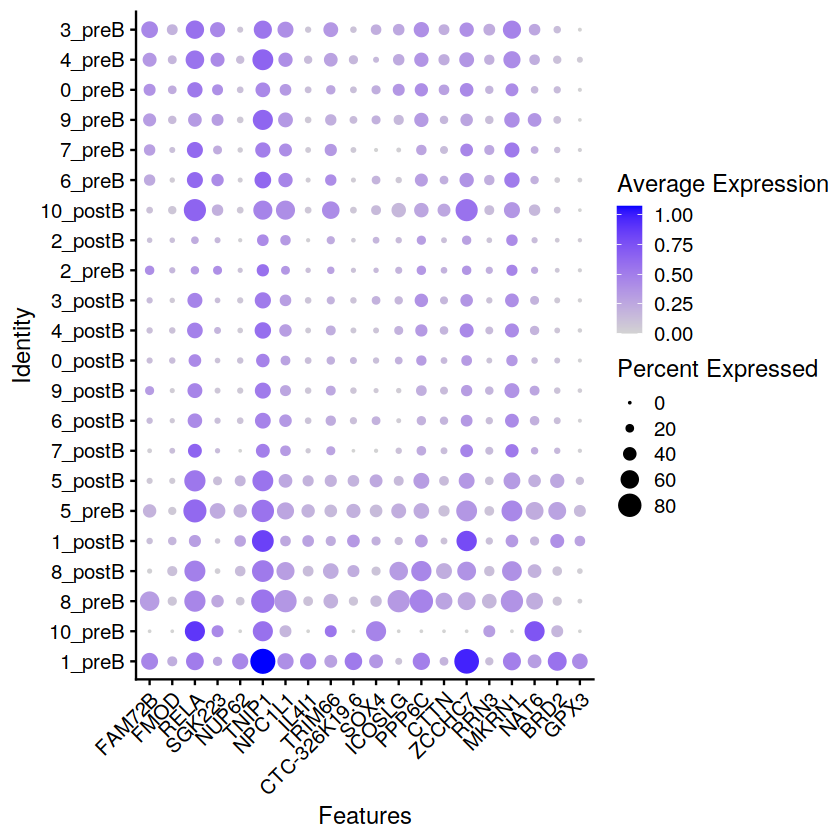

In [18]:
sig.all.ordered <- sort(rowMeans(-log10(all.pvals),na.rm=T), decreasing=T)
dot <- DotPlot(se, scale=F,
               features = head(names(sig.all.ordered),20), 
               cluster.idents=T) + RotatedAxis()
dot


--------

In [19]:
sessionInfo()

R version 4.1.1 (2021-08-10)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Ubuntu 20.04.3 LTS

Matrix products: default
BLAS/LAPACK: /home/isaac/miniconda3/envs/mttrace/lib/libopenblasp-r0.3.18.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats4    stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] future_1.23.0             RColorBrewer_1.1-2       
 [3] metap_1.1                 cowplot_1.1.1            
 [5] magrittr_2.0.1            data.table_1.14.2        
 [7] patchwork_1.1.1           ggplot2_3.3.5            
 [9] EnsDb.Hsapiens.v75_2.99.0 ensembldb_2.18.1         
[11] 

## Run DE for  cluster vs all others 

In [6]:
btwnClust.outdir <- file.path(outdir, "btwnClust")
dir.create(btwnClust.outdir)


Warning message in dir.create(btwnClust.outdir):
"'/data/Mito_Trace/output/pipeline/DUPI_april08_2021/MTblacklist_mtasnucl_Bonly/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_3/concat/annotation_clones/peaks_donors_DE_minPct_00/btwnClust' already exists"


In [ ]:
curr.outdir <- btwnClust.outdir

cluster.ids <- sort(unique(se$seurat_clusters))
Idents(se) <- se$seurat_clusters

all.pvals <- data.frame(matrix(nrow=dim(se)[1],ncol=0),
                          row.names=row.names(se))
all.names.sig <- c()
for (id1 in cluster.ids){ #or however many clusters you have
    try({
        print(paste("cluster", id1))
        response <- FindMarkers(
                      object = se,
                      ident.1 = id1, #"CD4 Naive",
                      min.pct = minPct,
                      test.use = test.use, latent.vars = latent.vars
                    )
        response$p_val_adj_BH <- stats::p.adjust(response$p_val, method = "BH", n = length(response$p_val)) 
        response <- response %>% dplyr::arrange(p_val_adj_BH)
        print(head(response))
        #write.csv(response, file=file.path(clust_outdir, paste0("cluster_",i,"vsAll.DE.csv")))
        curr.sig <- response %>% dplyr::filter(p_val_adj_BH<p_thresh)
        names.sig <- rownames(curr.sig)
        se.filt <- subset(se, seurat_clusters == id1)

        print(paste('saved cluster', id1))
 
        if (assay == "ATAC"){
            response.features <- ClosestFeature(se, regions = rownames(response))
            response.features = response.features %>% dplyr::mutate(gene.id = paste(gene_name,type, sep="_"))
            response$gene.id = response.features$gene.id
            feature.names.sig <- response[names_sig, "gene.id"]
        }else{
            feature.names.sig <- names_sig
        }
        write.csv(response,
                  file=file.path(curr.outdir, paste0("cluster",id1,".DE.csv")), quote=F)
        
        de.plots(se.filt, names.sig, curr.outdir, curr.name=id1, max.size=10, to.heat=T,to.vln=T, 
                 feature.names=feature.names.sig)
        # Add to all pvals
        all.names.sig <- c(all.names.sig, head(names.sig, top_de))
        all.pvals[names.sig,id1] <- curr.sig$p_val_adj_BH

    })
}


all.names.sig <- unique(all.names.sig)
de.plots(se, all.names.sig, curr.outdir, curr.name="allDonors.allClusters", max.size=15)

dot <- DotPlot(se, scale=FALSE,
               features = head(all.names.sig,20), 
               cluster.idents=T) + RotatedAxis()
dot
ggsave(file.path(curr.outdir, "allClusters.top3de.png"))
ggsave(file.path(curr.outdir, "allClusters.top3de.pdf"))

## b) averaged top p-values (only average ones that were DE)

sig.all.ordered <- sort(rowMeans(-log10(all.pvals),na.rm=T), decreasing=T)
dot <- DotPlot(se, scale=F,
               features = names(head(sig.all.ordered,20)), 
               cluster.idents=T) + RotatedAxis()
dot
ggsave(file.path(curr.outdir, "allClusters.pvalsOrdered..scaleF.png"))
ggsave(file.path(curr.outdir, "allClusters.pvalsOrdered.scaleF.pdf"))
#de.plots(se, names(sig.all.ordered), outdir, curr.name="allDonors.allClusters.pvalsOrdered", max.size=20)



all.pvals.nafill <- all.pvals
all.pvals.nafill[,] <- -log10(zoo::na.fill(all.pvals,1))

sig.all.ordered <- sort(rowMeans(all.pvals.nafill), decreasing=T)
dot <- DotPlot(se, scale=F,
               features = head(names(sig.all.ordered),20), 
               cluster.idents=F) + RotatedAxis() + ylab("Cluster")
ggsave(file.path(btwnClust.outdir,
                 "allClusters.ovalsOrderedNA.scaleF.png"))
ggsave(file.path(btwnClust.outdir,
                 "allClusters.ovalsOrderedNA.scaleF.pdf"))
dot

[1] "cluster 0"
                                p_val avg_log2FC pct.1 pct.2    p_val_adj
chr17-82126354-82128111  3.575789e-44  0.5283804 0.416 0.209 1.513203e-39
chr19-16368699-16370559  6.937084e-40  0.4883807 0.379 0.203 2.935635e-35
chr2-113876405-113877287 2.684604e-37  0.5642470 0.238 0.083 1.136071e-32
chr10-62183251-62184119  4.848188e-36  0.5622197 0.290 0.115 2.051656e-31
chr13-73984798-73985553  1.588710e-35  0.5670805 0.217 0.072 6.723104e-31
chr6-167112729-167114887 1.458550e-31 -0.5423227 0.004 0.134 6.172291e-27
                         p_val_adj_BH
chr17-82126354-82128111  4.848770e-41
chr19-16368699-16370559  4.703343e-37
chr2-113876405-113877287 1.213441e-34
chr10-62183251-62184119  1.643536e-33
chr13-73984798-73985553  4.308582e-33
chr6-167112729-167114887 3.296323e-29
[1] "saved cluster 0"
Error in `[.data.frame`(response, names_sig, "gene.id") : 
  object 'names_sig' not found
[1] "cluster 1"


Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"


In [23]:
btwn_embeddings <- file.path(btwnClust.outdir, "embeddings")
dir.create(btwn_embeddings)


featplot <- function(name.sig, se, curr.outdir){
    feat <- FeaturePlot(se,  features=name.sig)
    ggsave(plot=feat,
           file=file.path(curr.outdir, paste0(name.sig,".embedFeat.top.png")))
    }

sapply(all.names.sig, FUN=featplot, se=se, curr.outdir=btwn_embeddings)

Warning message in dir.create(btwn_embeddings):
"'/data/Mito_Trace/output/pipeline/DUPI_april08_2021/MTblacklist_mtasnucl_Bonly/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_3/concat/annotation_clones/genes_donors_DE_minPct_00/btwnClust/embeddings' already exists"
Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image


PLCG2 
       "/data/Mito_Trace/output/pipeline/DUPI_april08_2021/MTblacklist_mtasnucl_Bonly/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_3/concat/annotation_clones/genes_donors_DE_minPct_00/btwnClust/embeddings/PLCG2.embedFeat.top.png" 
                                                                                                                                                                                                                                                                                                                                 ANKRD44 
     "/data/Mito_Trace/output/pipeline/DUPI_april08_2021/MTblacklist_mtasnucl_Bonly/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_3/concat/annotation_clones/genes_donors_DE_minPct_00/btwnClust/embeddings/ANKRD44.embedFeat.top.png" 
                                                                                                                                                                                                                                                                                                                                  TVP23A 
      "/data/Mito_Trace/output/pipeline/DUPI_april08_2021/MTblacklist_mtasnucl_Bonly/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_3/concat/annotation_clones/genes_donors_DE_minPct_00/btwnClust/embeddings/TVP23A.embedFeat.top.png" 
                                                                                                                                                                                                                                                                                                                                   MAPK1 
       "/data/Mito_Trace/output/pipeline/DUPI_april08_2021/MTblacklist_mtasnucl_Bonly/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_3/concat/annotation_clones/genes_donors_DE_minPct_00/btwnClust/embeddings/MAPK1.embedFeat.top.png" 
                                                                                                                                                                                                                                                                                                                                  CDC123 
      "/data/Mito_Trace/output/pipeline/DUPI_april08_2021/MTblacklist_mtasnucl_Bonly/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_3/concat/annotation_clones/genes_donors_DE_minPct_00/btwnClust/embeddings/CDC123.embedFeat.top.png" 
                                                                                                                                                                                                                                                                                                                                    GNG7 
        "/data/Mito_Trace/output/pipeline/DUPI_april08_2021/MTblacklist_mtasnucl_Bonly/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_3/concat/annotation_clones/genes_donors_DE_minPct_00/btwnClust/embeddings/GNG7.embedFeat.top.png" 
                                                                                                                                                                                                                                                                                                                                   MOB3A 
       "/data/Mito_Trace/output/p